In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance_metrics import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance_metrics as perf
import trend_following as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)

<module 'trend_following' from '/Users/adheerchauhan/Documents/git/trend_following/trend_following.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper functions to help pull the data and run the analysis

### Moving Average and Donchian Channels Signals

In [30]:
from strategy_performance_metrics import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance(df_performance, ticker):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'{ticker} Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'{ticker} Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'{ticker} Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='price',
                                                rolling_donchian_window=20, long_only=False, use_coinbase_data=True):
    
    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, 
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close']].rename(columns={'close':ticker}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

    # Generate Trend Signal
    df_trend = (tf.create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))
    # Generate Donchian Channels
    df_donchian = tf.calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                            rolling_donchian_window=rolling_donchian_window, use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
        (df_donchian[f'close'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
        np.where((df_donchian[f'close'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']), -1, 0))

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}',
                     f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_signal']
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    # Trend and Donchian Channel Signal
    buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                  (df_trend[f'{ticker}_trend_signal'] == 1))
    sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                   (df_trend[f'{ticker}_trend_signal'] == -1))

    # Generate Long Only Signal
    if long_only:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, 0))
    # Generate Long & Short Signal
    else:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, np.where(sell_signal, -1, 0)))
        
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')] * 
        df_trend[f'{ticker}_pct_returns'])
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')].diff())
    
    return df_trend

def moving_avg_crossover_with_donchian_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='price',
                                                           rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    perf_cols = ['ticker', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    fast_mavg_list = np.arange(10, 101, 10)
    slow_mavg_list = np.arange(50, 501, 50)
    mavg_stepsize_list = [2, 4, 6, 8]
    performance_rows = []
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for mavg_stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df_trend = generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type, price_or_returns_calc,
                                                                         rolling_donchian_window, include_signal_strength, long_only, use_coinbase_data)
                    performance_metrics = calculate_risk_and_performance_metrics(
                        df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                        strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                        annual_trading_days=365, transaction_cost_est=0.005)
                    performance_rows.append({
                        'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': mavg_stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    })
                    # df_performance = df_performance.append(row, ignore_index=True)
    # Convert the list of rows to a DataFrame
    df_performance = pd.DataFrame(performance_rows, columns=perf_cols)
    
    plot_moving_avg_crossover_performance(df_performance, ticker)
    
    return df_performance

# Position Sizing Strategies

In [20]:
## In Sample Performance
# in_sample_start_date = pd.Timestamp(2014, 9, 17).date()
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2022, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2023, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2024, 9, 30).date()
full_sample_start_date = pd.Timestamp(2014, 9, 17).date()
full_sample_end_date = pd.Timestamp(2024, 9, 30).date()

In [22]:
def calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc='price', rolling_atr_window=20,
                                 use_coinbase_data=True):
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose', f'{ticker}_volume']

    
    ## Get T-1 Close Price
    df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
    
    if price_or_returns_calc == 'price':
        # Calculate the Exponential Moving Average (EMA)
        # df[f'{ticker}_{rolling_atr_window}_ema_price'] = df['close'].ewm(span=rolling_atr_window,
        #                                                                  adjust=False).mean()

        # Calculate the True Range (TR) and Average True Range (ATR)
        df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
        df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_true_range_price'] = df[
            [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        # Calculate Middle Line as the EMA of returns
        df[f'{ticker}_{rolling_atr_window}_ema_returns'] = df[f'{ticker}_pct_returns'].ewm(span=rolling_atr_window,
                                                                                           adjust=False).mean()

        # Calculate True Range based on absolute returns
        df[f'{ticker}_true_range_returns'] = df[f'{ticker}_{rolling_atr_window}_ema_returns'].abs()

        # Calculate ATR using the EMA of the True Range
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'] = df[f'{ticker}_true_range_returns'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    return df

In [32]:
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
moving_avg_type = 'exponential'
price_or_returns_calc = 'price'
rolling_donchian_window = 20
ticker_dict = cn.coinbase_start_date_by_ticker_dict
# ticker='BTC-USD'

perf_cols = ['ticker', 'start_date', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
            'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_performance = pd.DataFrame(columns=perf_cols)

for ticker in ticker_dict.keys():
    print(ticker)
    if pd.to_datetime(ticker_dict[ticker]).date() > in_sample_end_date:
        pass
    elif in_sample_start_date < pd.to_datetime(ticker_dict[ticker]).date():
        df_trend = generate_trend_signal_with_donchian_channel(start_date=pd.to_datetime(ticker_dict[ticker]).date(), end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                               mavg_stepsize=mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc,
                                                               rolling_donchian_window=rolling_donchian_window)
        performance_metrics = perf.calculate_risk_and_performance_metrics(
            df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
            strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades', passive_trade_rate=0.05,
            annual_trading_days=365)
        row = {
            'ticker': ticker,
            'start_date': ticker_dict[ticker],
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    else:
        df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                               mavg_stepsize=mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc,
                                                               rolling_donchian_window=rolling_donchian_window)
        performance_metrics = perf.calculate_risk_and_performance_metrics(
            df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
            strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades', passive_trade_rate=0.05,
            annual_trading_days=365)
        row = {
            'ticker': ticker,
            'start_date': ticker_dict[ticker],
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    # performance_metrics = perf.calculate_risk_and_performance_metrics(
    #     df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
    #     strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades', passive_trade_rate=0.05,
    #     annual_trading_days=365)
    

BTC-USD
ETH-USD
SOL-USD
LTC-USD
DOGE-USD
CRO-USD
ADA-USD
AVAX-USD
XRP-USD
SHIB-USD
LINK-USD
UNI-USD
DOT-USD
FET-USD
ALGO-USD
DAI-USD
AAVE-USD
XLM-USD
MATIC-USD
ATOM-USD
MANA-USD
OXT-USD
KRL-USD
AMP-USD
REQ-USD
SKL-USD
GRT-USD
MOBILE-USD
AIOZ-USD
ZRO-USD
HNT-USD
HONEY-USD


In [34]:
df_performance

,ticker,start_date,fast_mavg,slow_mavg,stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count
0,BTC-USD,2016-01-01,50,250,6,4.341954,3.574038,0.838253,0.331438,-5.179763,265 days,0.116608,9.828014,2.123179e-22,276.0
1,ETH-USD,2016-05-01,50,250,6,10.512727,4.039983,199.390659,0.512257,-0.052724,228 days,0.103864,10.616843,9.158998e-26,240.0
2,SOL-USD,2021-06-01,50,250,6,44.424731,4.936444,486.612355,0.680045,-0.091294,70 days,0.153707,6.158468,1.415381e-09,78.0
3,LTC-USD,2016-08-01,50,250,6,7.753411,2.851498,0.744623,0.668618,-10.412529,190 days,0.072939,7.366585,2.421572e-13,206.0
4,DOGE-USD,2021-05-01,50,250,6,4.519804,3.548607,34.122754,0.349819,-0.132457,104 days,0.100529,4.592356,5.405114e-06,64.0
5,CRO-USD,2021-10-01,50,250,6,23.964827,4.535898,323.540579,0.575269,-0.074071,50 days,0.128019,4.914726,1.284490e-06,68.0
6,ADA-USD,2021-03-01,50,250,6,11.275913,4.215454,148.524527,0.456153,-0.075920,94 days,0.128882,5.736692,1.486945e-08,92.0
7,AVAX-USD,2021-09-01,50,250,6,25.264947,4.771648,273.310639,0.567736,-0.092440,81 days,0.140625,5.375142,1.234870e-07,68.0
8,SHIB-USD,2021-08-01,50,250,6,13.225624,2.985286,143.111834,0.789007,-0.092415,122 days,0.091684,3.450223,6.108435e-04,54.0
9,LINK-USD,2019-06-01,50,250,6,11.692013,4.040622,46.033910,0.493605,-0.253987,164 days,0.106750,7.730384,2.165425e-14,174.0


In [36]:
print(f'Annualized Return: {df_performance['annualized_return'].mean()}')
print(f'Sharpe Ratio: {df_performance['sharpe_ratio'].mean()}')

Annualized Return: 16.777853943641535
Sharpe Ratio: 3.5435932727312283


## Position Sizing using Average True Range

In [402]:
## Position Sizing Strategy will calculate Account Risk based on risk tolerance per trade and Trade Risk based on ATR or stop loss multiple
## Position Size will be determined by dividing the Account Risk by the Trade Risk
def get_position_sizing_using_atr(start_date, end_date, ticker_list, rolling_atr_window, initial_capital, risk_per_trade, stop_loss_multiple):

    atr_list = []
    for ticker in ticker_list:
        df_atr = calculate_average_true_range(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc='price',
                                              rolling_atr_window=rolling_atr_window, use_coinbase_data=True)
        
        ## Calculate Target Size and Notional based on the Average True Range
        target_size_col = f'{ticker}_target_size'
        target_notional_col = f'{ticker}_target_notional'
        atr_cols = [f'{ticker}_t_1_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price', target_size_col, target_notional_col]
        df_atr[target_size_col] = (initial_capital * risk_per_trade)/(df_atr[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] * stop_loss_multiple)
        df_atr[target_notional_col] = df_atr[f'{ticker}_target_size'] * df_atr[f'{ticker}_t_1_close']
        atr_list.append(df_atr[atr_cols])
        
    df_atr_ticker = pd.concat(atr_list, axis=1)
    
    ## Check if the sum of the target notionals for all tickers exceeds the initial capital
    df_atr_ticker['scaling_factor'] = 1
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    df_atr_ticker[f'total_target_notional'] = df_atr_ticker[target_notional_cols].sum(axis=1)
    df_atr_ticker['scaling_factor'] = np.where(df_atr_ticker['total_target_notional'] > initial_capital, 
                                               initial_capital/df_atr_ticker['total_target_notional'], 1)
    df_atr_ticker[target_notional_cols] = (
        df_atr_ticker[target_notional_cols].multiply(df_atr_ticker['scaling_factor'], axis=0))
    
    df_atr_ticker[f'total_target_notional'] = df_atr_ticker[target_notional_cols].sum(axis=1)
    df_atr_ticker['initial_capital'] = initial_capital
    
    return df_atr_ticker

In [212]:
ticker_list = ['BTC-USD','ETH-USD']#,'SOL-USD','LTC-USD']
df_target_position = get_position_sizing_using_atr(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_atr_window=20, 
                                                   initial_capital=20000, risk_per_trade=0.02, stop_loss_multiple=1)

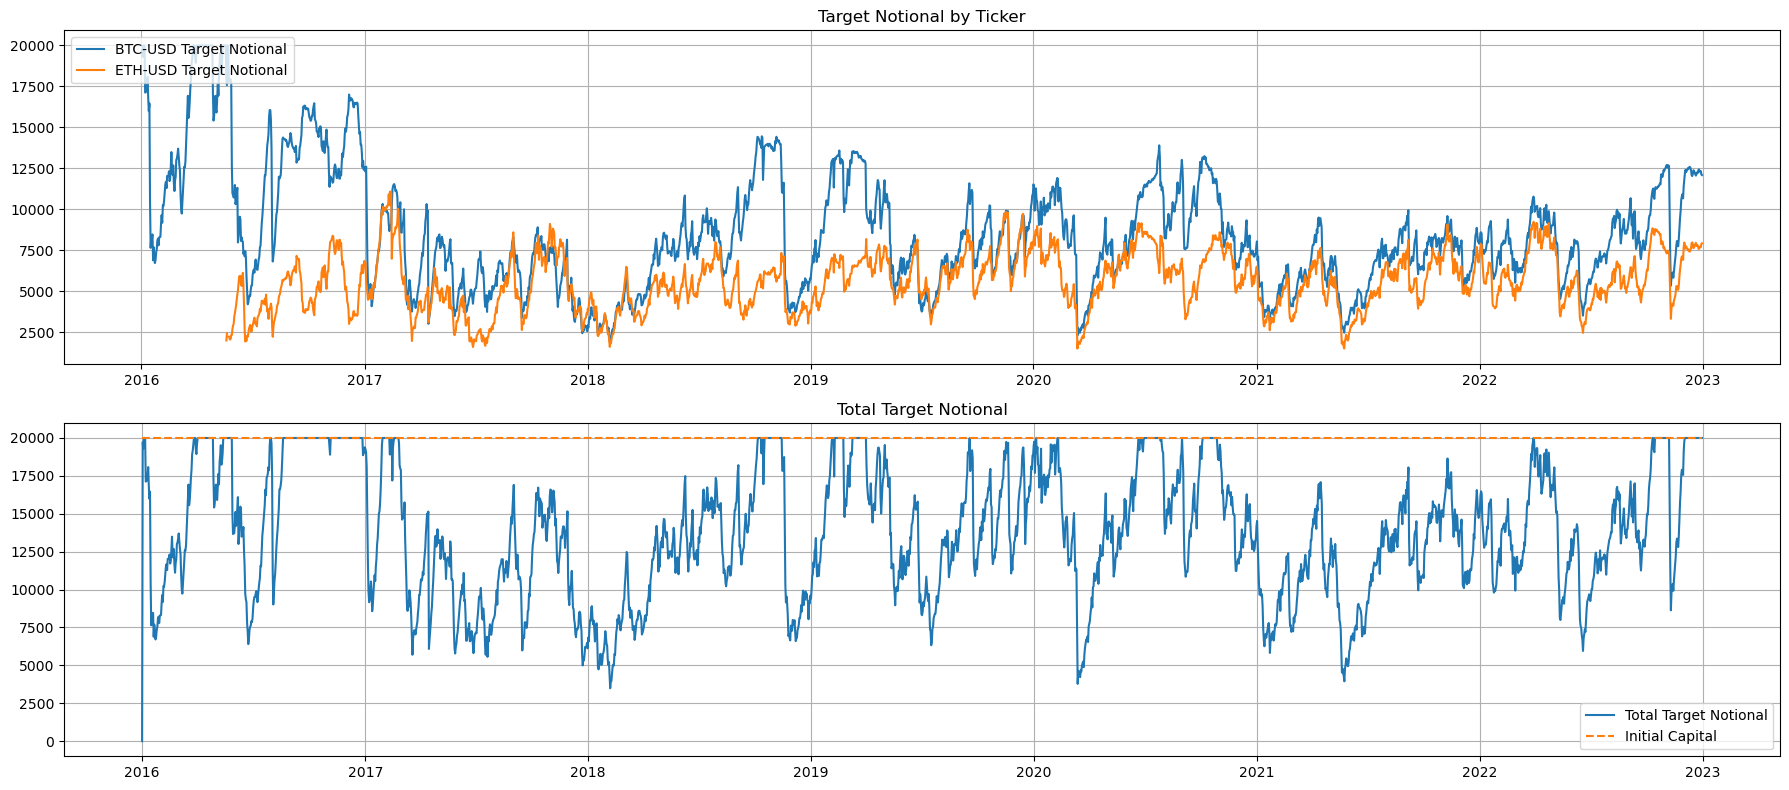

In [216]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
target_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
total_target_notional_ax = plt.subplot2grid(layout, (1,0), colspan=2)

# date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = target_notional_ax.plot(df_target_position.index, df_target_position[f'{ticker}_target_notional'], label=f'{ticker} Target Notional')
_ = total_target_notional_ax.plot(df_target_position.index, df_target_position[f'total_target_notional'], label=f'Total Target Notional')
_ = total_target_notional_ax.plot(df_target_position.index, df_target_position[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = target_notional_ax.grid()
_ = target_notional_ax.legend(loc='upper left')
_ = target_notional_ax.set_title(f'Target Notional by Ticker')

_ = total_target_notional_ax.grid()
_ = total_target_notional_ax.legend(loc='lower right')
_ = total_target_notional_ax.set_title(f'Total Target Notional')

plt.tight_layout()

In [218]:
def reorder_columns_by_ticker(columns, tickers):
    ordered_columns = []
    for ticker in tickers:
        # Find all columns for this ticker
        ticker_columns = [col for col in columns if col.startswith(f"{ticker}")]
        # Add them to the ordered list
        ordered_columns.extend(sorted(ticker_columns))  # Sorting ensures a predictable order (e.g., open, close, volume)
    return ordered_columns

In [220]:
def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only=False):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:
        close_price_col = f'{ticker}'
        t_1_close_price_col = f'{ticker}_t_1_close'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel(start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                             mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                             long_only=long_only)
        else:
            df_trend = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                             mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                             long_only=long_only)
        trend_cols = [close_price_col, signal_col, returns_col, trades_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [222]:
def get_daily_portfolio_positions(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window):

    ## Reorder dataframe columns
    col_list = []
    for ticker in ticker_list:
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_actual_position_entry_price'] = 0.0
        df[f'{ticker}_actual_position_exit_price'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_actual_size'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = reorder_columns_by_ticker(df.columns, ticker_list)
    ord_cols.extend(['scaling_factor','total_target_notional','initial_capital'])
    df = df[ord_cols]

    ## Identify Daily Positions
    for i in range(1, len(df)):
        for ticker in ticker_list:
            t_1_close_price_col = f'{ticker}_t_1_close'
            signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
            target_position_notional_col = f'{ticker}_target_notional'
            target_position_size_col = f'{ticker}_target_size'
            actual_position_notional_col = f'{ticker}_actual_position_notional'
            actual_position_size_col = f'{ticker}_actual_size'
            actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
            actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'
            short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
            event_col = f'{ticker}_event'
            df[actual_position_notional_col][i] = 0.0
            df[actual_position_entry_price_col][i] = 0.0
            df[actual_position_size_col][i] = 0.0
            df[event_col][i] = np.nan
            
            ## Taking a New Long position
            if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
                df[actual_position_notional_col][i] = df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[event_col][i] = 'New Long Position'
                
            ## Taking a New Short position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
                df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = -df[actual_position_notional_col][i]
                df[event_col][i] = 'New Short Position'
                
            ## Amending an Open Long Position
            elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_size_col][i] = df[actual_position_size_col][i-1]
                df[actual_position_notional_col][i] = df[actual_position_size_col][i] * df[t_1_close_price_col][i]
                df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
                df[event_col][i] = 'Open Long Position'
                
            ## Amending an Open Short Position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_size_col][i] = df[actual_position_size_col][i-1]
                df[actual_position_notional_col][i] = df[actual_position_size_col][i] * df[t_1_close_price_col][i]
                df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
                df[short_sale_proceeds_col][i] = df[short_sale_proceeds_col][i-1]
                df[event_col][i] = 'Open Short Position'
                
            ## Taking a New Long Position with an Open Short Position
            elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_notional_col][i] = df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = 0.0
                df[event_col][i] = 'New Long with Open Short Position'
                
            ## Taking a New Short Position with an Existing Long Position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = -df[actual_position_notional_col][i]
                df[event_col][i] = 'New Short with Open Long Position'
            
            ## Closing a Long Position
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[actual_position_exit_price_col][i] = df[t_1_close_price_col][i]
                df[event_col][i] = 'Closing Long Position'
                
            ## Closing a Short Position
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[actual_position_exit_price_col][i] = df[t_1_close_price_col][i]
                df[short_sale_proceeds_col][i] = 0.0
                df[event_col][i] = 'Closing Short Position'

            ## No Event
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[short_sale_proceeds_col][i] = 0
                df[event_col][i] = 'No Event'

    return df

In [224]:
def get_portfolio_cash_and_market_value(df, initial_capital, ticker_list):

    ## Calculate the available cash for the portfolio
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    
    ## Cash on Day 1 is all of the initial capital
    df['available_cash'][0] = initial_capital
    df['total_portfolio_value'][0] = initial_capital
    
    event_cols = [f'{ticker}_event' for ticker in ticker_list]
    actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
    actual_position_size_cols = [f'{ticker}_actual_size' for ticker in ticker_list]
    exit_price_cols = [f'{ticker}_actual_position_exit_price' for ticker in ticker_list]
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
    
    for i in range(1, len(df)):
        ## Start the day with the available cash from yesterday
        df['available_cash'][i] = df['available_cash'][i-1]
        
        ## New Long Position
        long_position_identifiers = ['New Long Position','New Long with Open Short Position']
        new_long_mask = df[event_cols].iloc[i].isin(long_position_identifiers)
        new_long_market_value = df[actual_position_notional_cols].iloc[i].where(new_long_mask.values).sum()
        df['available_cash'][i] = df['available_cash'][i] - new_long_market_value
    
        ## New Short Position
        short_position_identifiers = ['New Short Position','New Short with Open Long Position']
        new_short_mask = df[event_cols].iloc[i].isin(short_position_identifiers)
        new_short_market_value = -df[actual_position_notional_cols].iloc[i].where(new_short_mask.values).sum()
    
        ## Closing Long Position
        closing_long_mask = df[event_cols].iloc[i] == 'Closing Long Position'
        closing_long_masked_sizes = df[actual_position_size_cols].iloc[i-1].where(closing_long_mask.values).fillna(0).values
        closing_long_masked_prices = df[exit_price_cols].iloc[i].where(closing_long_mask.values).fillna(0).values
        closing_long_market_value = (closing_long_masked_sizes * closing_long_masked_prices).sum()
        df['available_cash'][i] = df['available_cash'][i] + closing_long_market_value

        ## Closing Short Position
        closing_short_mask = df[event_cols].iloc[i] == 'Closing Short Position'
        closing_short_masked_sizes = df[actual_position_size_cols].iloc[i-1].where(closing_short_mask.values).fillna(0).values
        closing_short_masked_prices = df[exit_price_cols].iloc[i].where(closing_short_mask.values).fillna(0).values
        closing_short_market_value = (closing_short_masked_sizes * closing_short_masked_prices).sum()
        short_sale_proceeds_value = df[short_sale_proceeds_cols].iloc[i-1].where(closing_short_mask.values).sum()
        df['available_cash'][i] = df['available_cash'][i] + (short_sale_proceeds_value + closing_short_market_value)

        ## Portfolio Positions
        df['count_of_positions'][i] = df[actual_position_notional_cols].iloc[i].ne(0).sum()
        df['total_actual_position_notional'][i] = df[actual_position_notional_cols].iloc[i].sum()
        df['total_portfolio_value'][i] = (df['available_cash'][i] +
                                          df[short_sale_proceeds_cols].iloc[i].sum() +
                                          df['total_actual_position_notional'][i])

    return df

In [412]:
def plot_portfolio_trend_following_performance(df, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(15,8))
    layout = (2,2)
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (1,1))#, colspan=2)

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_{rolling_sharpe_window}'], label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'Portfolio Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'], label='Return')
    _ = trend_return_ax.set_title(f'Trend Strategy with Donchian Channel Portfolio Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['portfolio_strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'Trend Strategy with Donchian Channel Portfolio Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

In [383]:
def apply_atr_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                       long_only=False, include_signal_strength=False, rolling_atr_window=20, stop_loss_multiple=1, transaction_cost_est=0.001, risk_per_trade=0.05, initial_capital=15000,
                                       passive_trade_rate=0.05, use_coinbase_data=True, rolling_sharpe_window=50):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                       mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, long_only=long_only)

    ## Generate Target Position Size and Notional for all tickers
    df_target_position = get_position_sizing_using_atr(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window, 
                                                       initial_capital=initial_capital, risk_per_trade=risk_per_trade, stop_loss_multiple=stop_loss_multiple)

    ## Merge the Trend and Target Position Dataframes
    df = pd.merge(df_trend, df_target_position, left_index=True, right_index=True, how='left')

    ## Get Daily Positions
    df = get_daily_portfolio_positions(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window)

    ## Calculate Available Cash and Portfolio Positions
    df = get_portfolio_cash_and_market_value(df, initial_capital, ticker_list)

    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    trade_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades' for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    average_fee_per_trade = perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
    adjusted_daily_returns = df[f'portfolio_daily_pct_returns'] - (df[f'portfolio_trade_count']) * (transaction_cost_est + average_fee_per_trade)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    df['portfolio_strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col='portfolio_trade_count'))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})
    
    plot_portfolio_trend_following_performance(df, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)
    
    return df

In [385]:
df_position_long_short[df_position_long_short.total_portfolio_value.isnull()].head()

,BTC-USD,BTC-USD_20_avg_true_range_price,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_event,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,ETH-USD,ETH-USD_20_avg_true_range_price,ETH-USD_50_6_250_mavg_crossover_20_donchian_signal,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,ETH-USD_actual_position_entry_price,ETH-USD_actual_position_exit_price,ETH-USD_actual_position_notional,ETH-USD_actual_size,ETH-USD_event,ETH-USD_short_sale_proceeds,ETH-USD_t_1_close,ETH-USD_target_notional,ETH-USD_target_size,LTC-USD,LTC-USD_20_avg_true_range_price,LTC-USD_50_6_250_mavg_crossover_20_donchian_signal,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,LTC-USD_actual_position_entry_price,LTC-USD_actual_position_exit_price,LTC-USD_actual_position_notional,LTC-USD_actual_size,LTC-USD_event,LTC-USD_short_sale_proceeds,LTC-USD_t_1_close,LTC-USD_target_notional,LTC-USD_target_size,SOL-USD,SOL-USD_20_avg_true_range_price,SOL-USD_50_6_250_mavg_crossover_20_donchian_signal,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,SOL-USD_actual_position_entry_price,SOL-USD_actual_position_exit_price,SOL-USD_actual_position_notional,SOL-USD_actual_size,SOL-USD_event,SOL-USD_short_sale_proceeds,SOL-USD_t_1_close,SOL-USD_target_notional,SOL-USD_target_size,scaling_factor,total_target_notional,initial_capital,available_cash,count_of_positions,total_actual_position_notional,total_portfolio_value,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


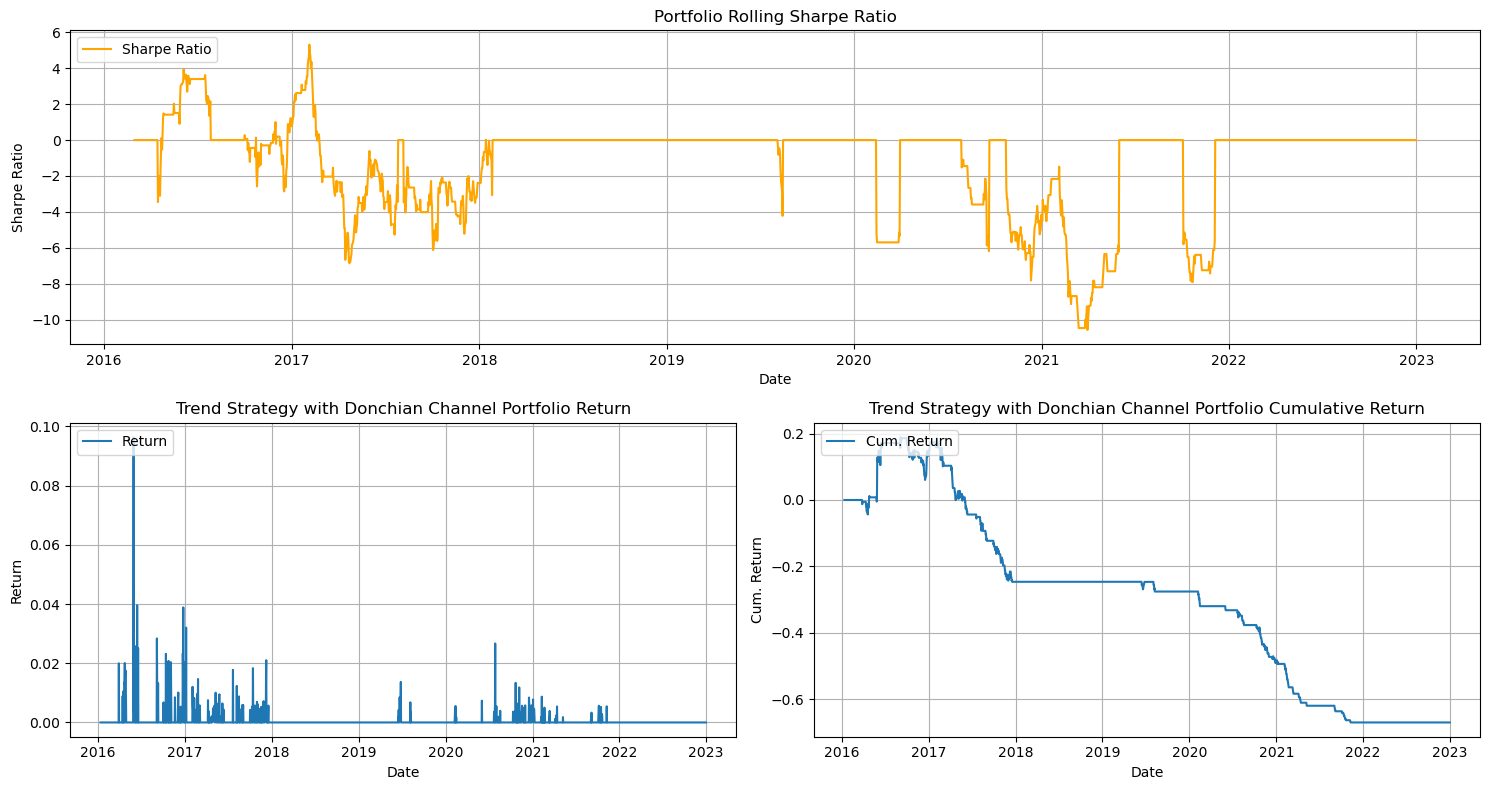

In [387]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only=True
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_long = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                      mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                      stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only)

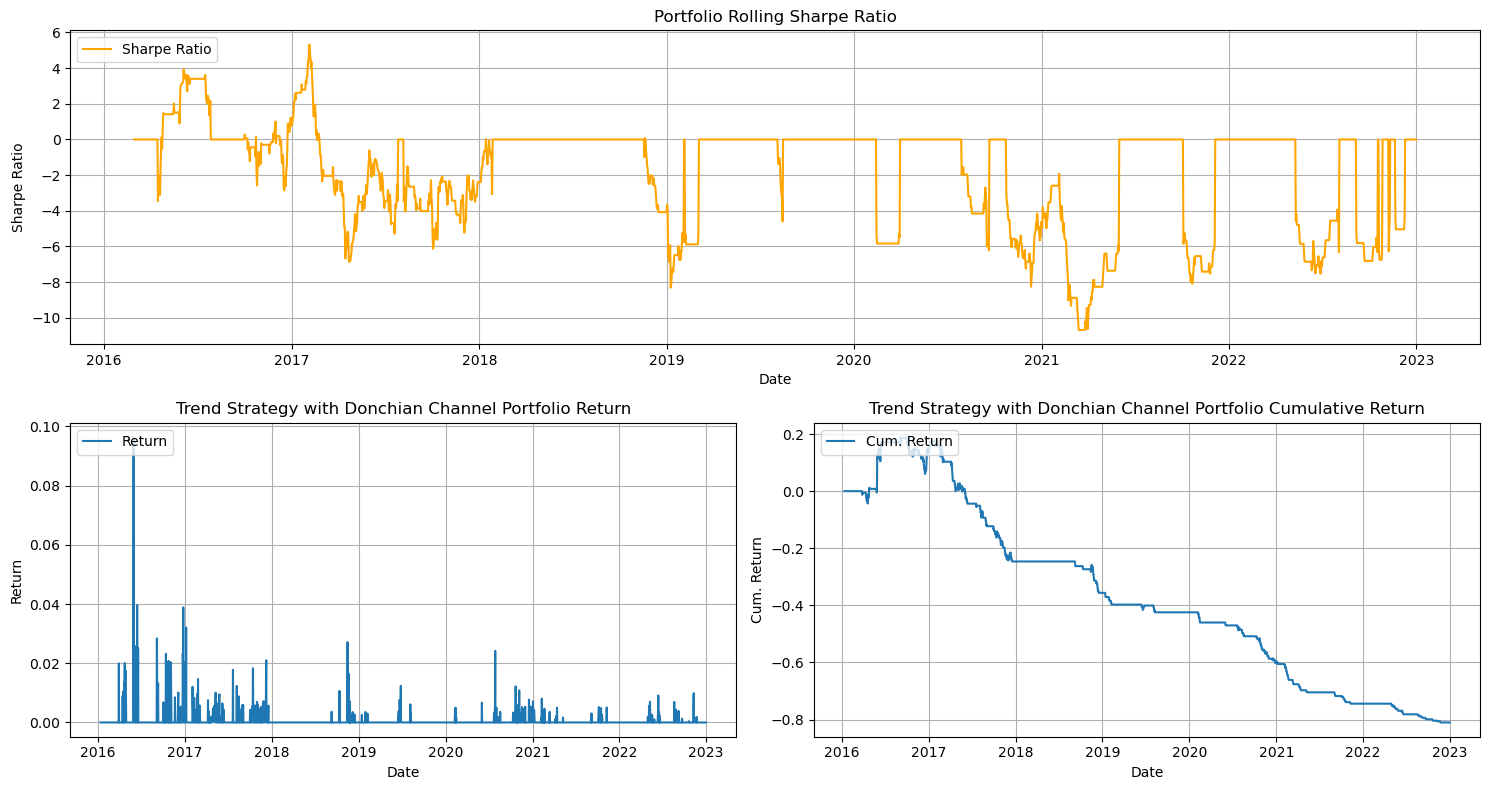

In [388]:
df_position_long_short = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                            mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                            stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=False)

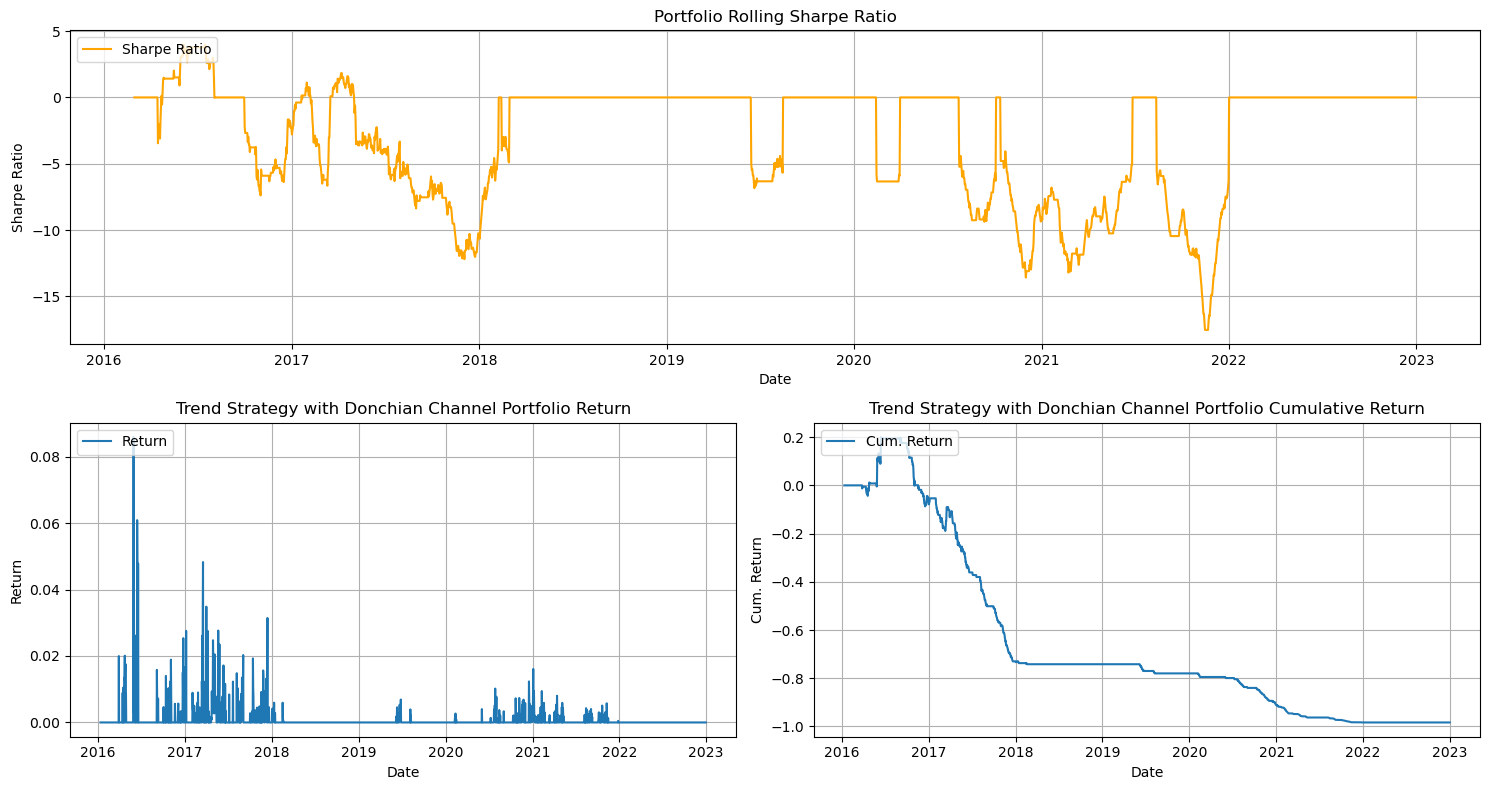

In [389]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only=True
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_long = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                      mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                      stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only)

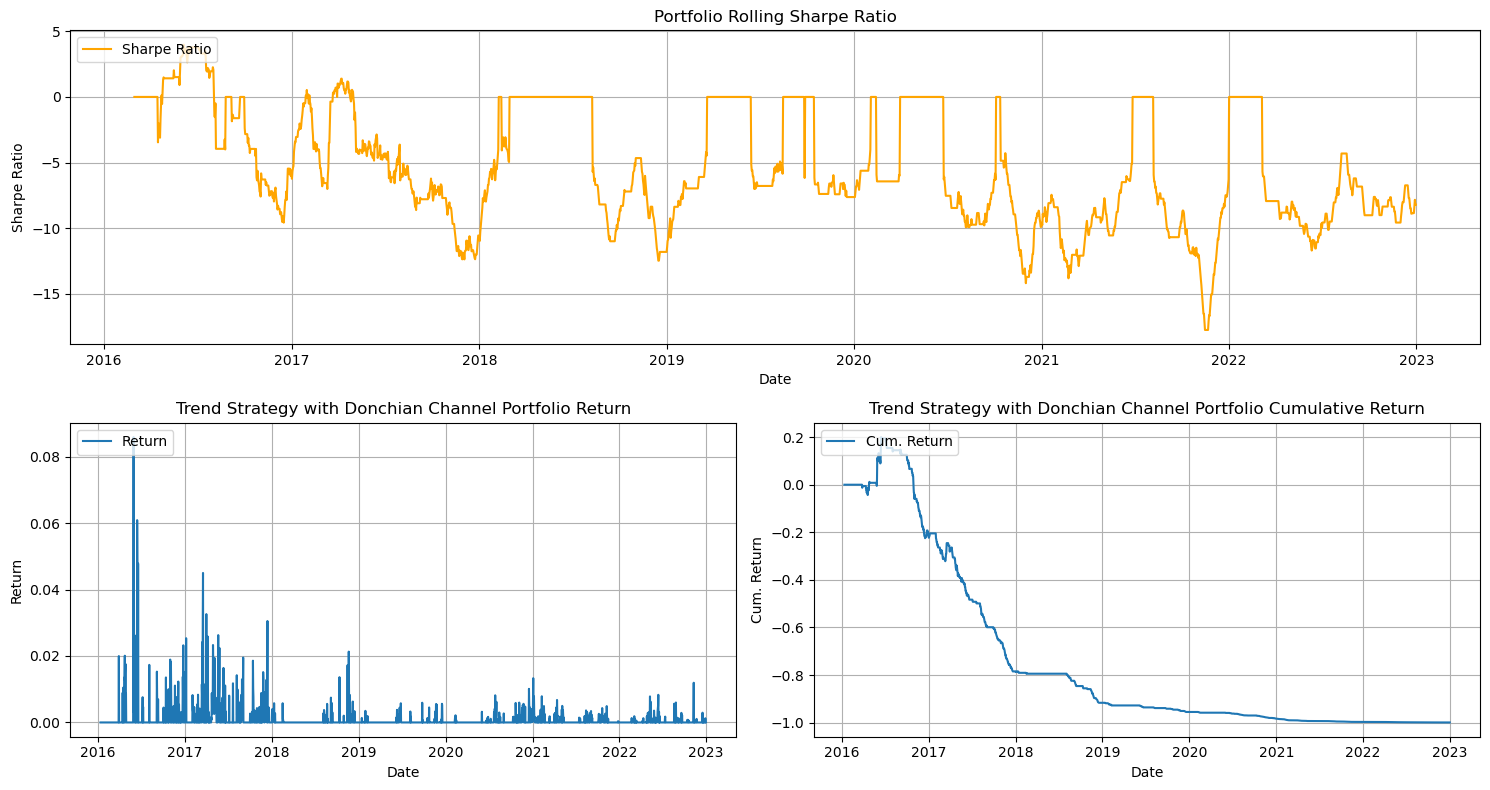

In [390]:
df_position_long_short = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                            mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                            stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=False)

In [274]:
perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='trade_count', annual_trading_days=365, passive_trade_rate=0.5)

{'annualized_return': 0.36921824806036385,
 'annualized_sharpe_ratio': -0.9618814929432689,
 'calmar_ratio': 0.27622694642235135,
 'annualized_std_dev': 0.09149323199948474,
 'max_drawdown': -1.3366481903464578,
 'max_drawdown_duration': Timedelta('1849 days 00:00:00'),
 'hit_rate': 0.08166470357283079,
 't_statistic': -1.1321951954297615,
 'p_value': 0.257658998457266,
 'trade_count': 276.0}

In [276]:
perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                                            strategy_trade_count_col='BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', annual_trading_days=365, passive_trade_rate=0.5)

{'annualized_return': 4.341958755962499,
 'annualized_sharpe_ratio': 3.872569503616915,
 'calmar_ratio': 1.7693848247824882,
 'annualized_std_dev': 0.33339720913707016,
 'max_drawdown': -2.4539369249401464,
 'max_drawdown_duration': Timedelta('265 days 00:00:00'),
 'hit_rate': 0.1193561052218296,
 't_statistic': 10.616407715431063,
 'p_value': 8.581212038288096e-26,
 'trade_count': 276.0}

In [278]:
perf.calculate_risk_and_performance_metrics(df_position_long, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='trade_count')#, annual_trading_days=365, passive_trade_rate=0.5)

{'annualized_return': 0.21105494705897376,
 'annualized_sharpe_ratio': -1.2541043364970303,
 'calmar_ratio': 0.10210602581673532,
 'annualized_std_dev': 0.0779905917595207,
 'max_drawdown': -2.0670175474049404,
 'max_drawdown_duration': Timedelta('2156 days 00:00:00'),
 'hit_rate': 0.0691009030231645,
 't_statistic': -1.9979594866440833,
 'p_value': 0.04582725430741248,
 'trade_count': 220.0}

In [280]:
perf.calculate_risk_and_performance_metrics(df_position_long, strategy_daily_return_col='BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                                            strategy_trade_count_col='BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', annual_trading_days=365, passive_trade_rate=0.5)

{'annualized_return': 2.8331060282905574,
 'annualized_sharpe_ratio': 3.467455157869295,
 'calmar_ratio': 1.154514608544659,
 'annualized_std_dev': 0.29589201218667543,
 'max_drawdown': -2.4539369249401464,
 'max_drawdown_duration': Timedelta('546 days 00:00:00'),
 'hit_rate': 0.10011778563015312,
 't_statistic': 9.595258564445622,
 'p_value': 1.9206052015217777e-21,
 'trade_count': 220.0}

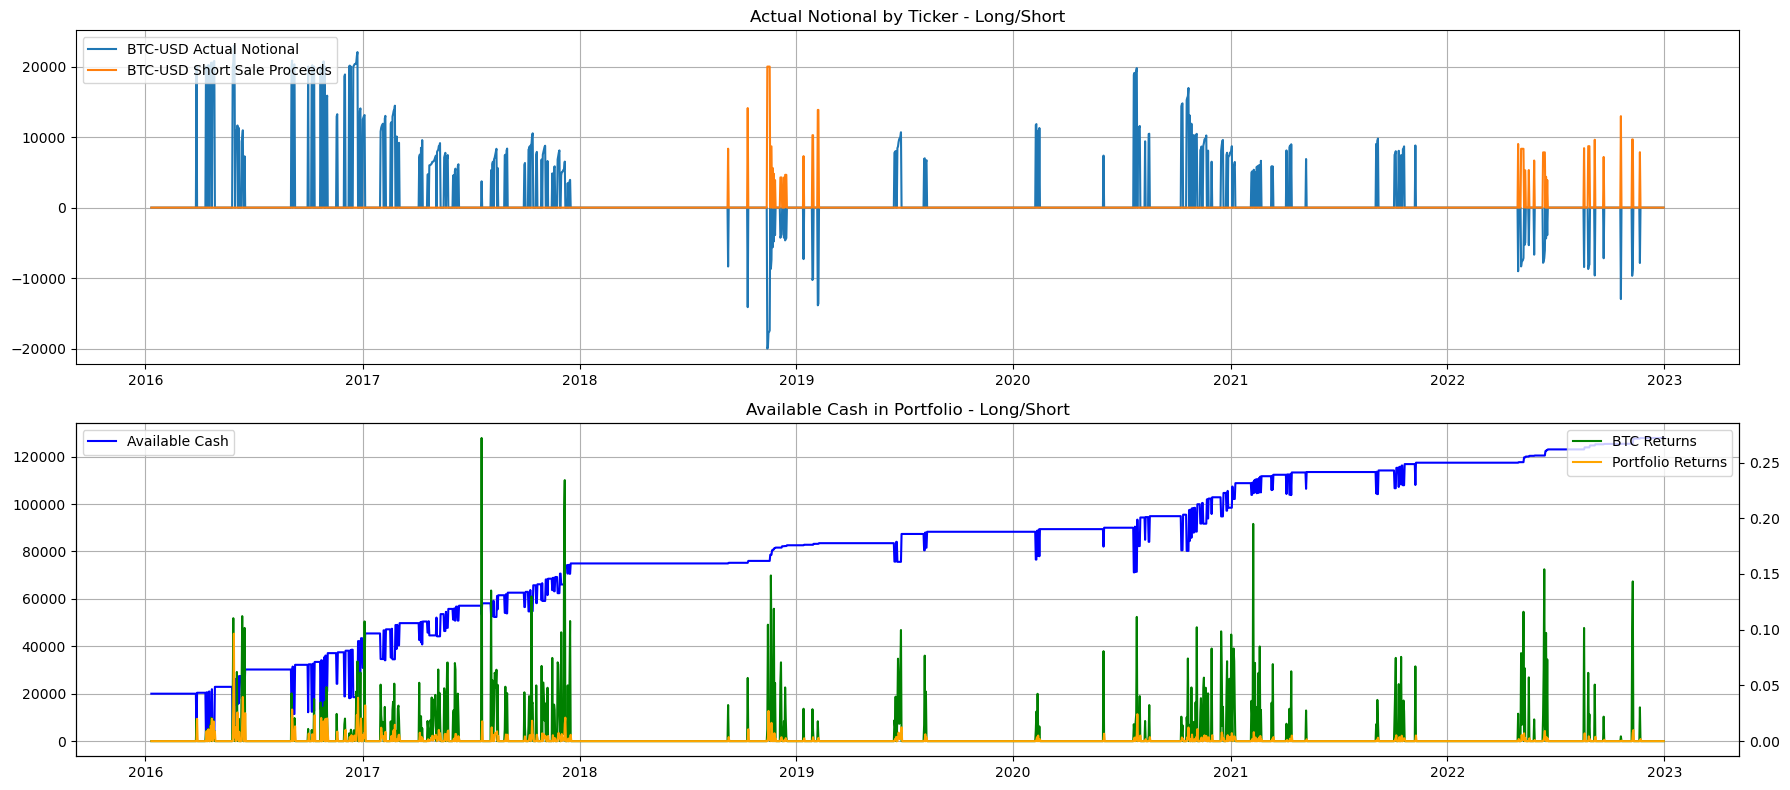

In [194]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position.index >= pd.Timestamp('2022-01-01').date()) & (df_position.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position.index, df_position[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    _ = actual_notional_ax.plot(df_position.index, df_position[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position.index, df_position[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax2.plot(df_position.index, df_position[f'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], label=f'BTC Returns', color='green')
_ = available_cash_ax2.plot(df_position.index, df_position[f'daily_pct_returns'], label=f'Portfolio Returns', color='orange')
# _ = available_cash_ax.plot(df_position.index, df_position[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long/Short')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long/Short')

plt.tight_layout()

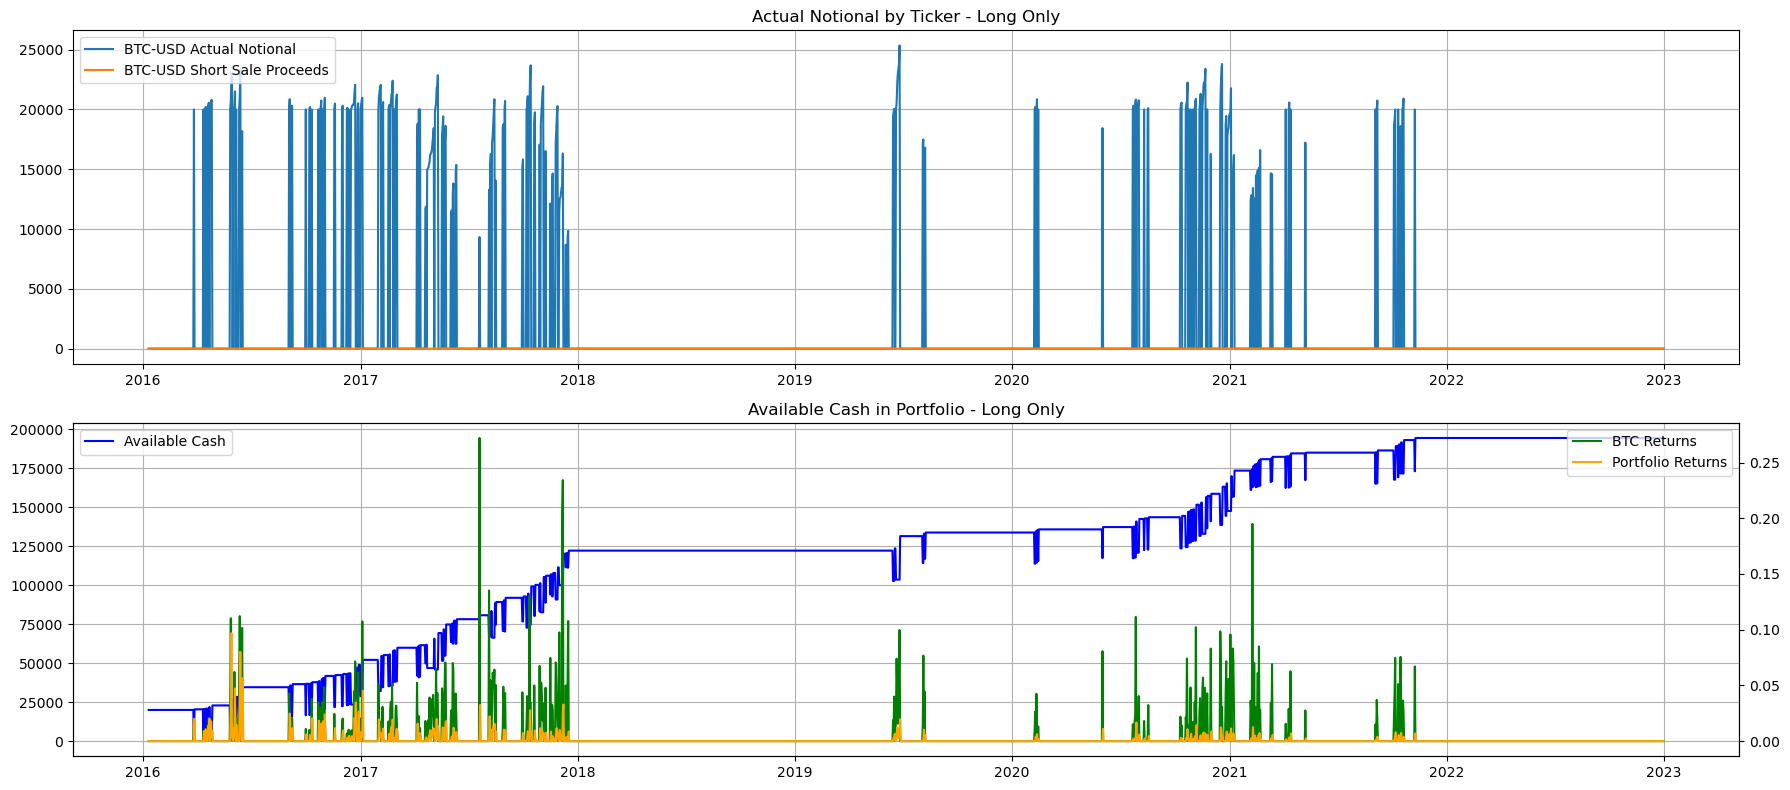

In [296]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position_long.index >= pd.Timestamp('2022-01-01').date()) & (df_position_long.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position_long.index, df_position_long[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    _ = actual_notional_ax.plot(df_position_long.index, df_position_long[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position_long.index, df_position_long[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax2.plot(df_position_long.index, df_position_long[f'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], label=f'BTC Returns', color='green')
_ = available_cash_ax2.plot(df_position_long.index, df_position_long[f'daily_pct_returns'], label=f'Portfolio Returns', color='orange')
# _ = available_cash_ax.plot(df_position_long.index, df_position_long[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long Only')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long Only')

plt.tight_layout()

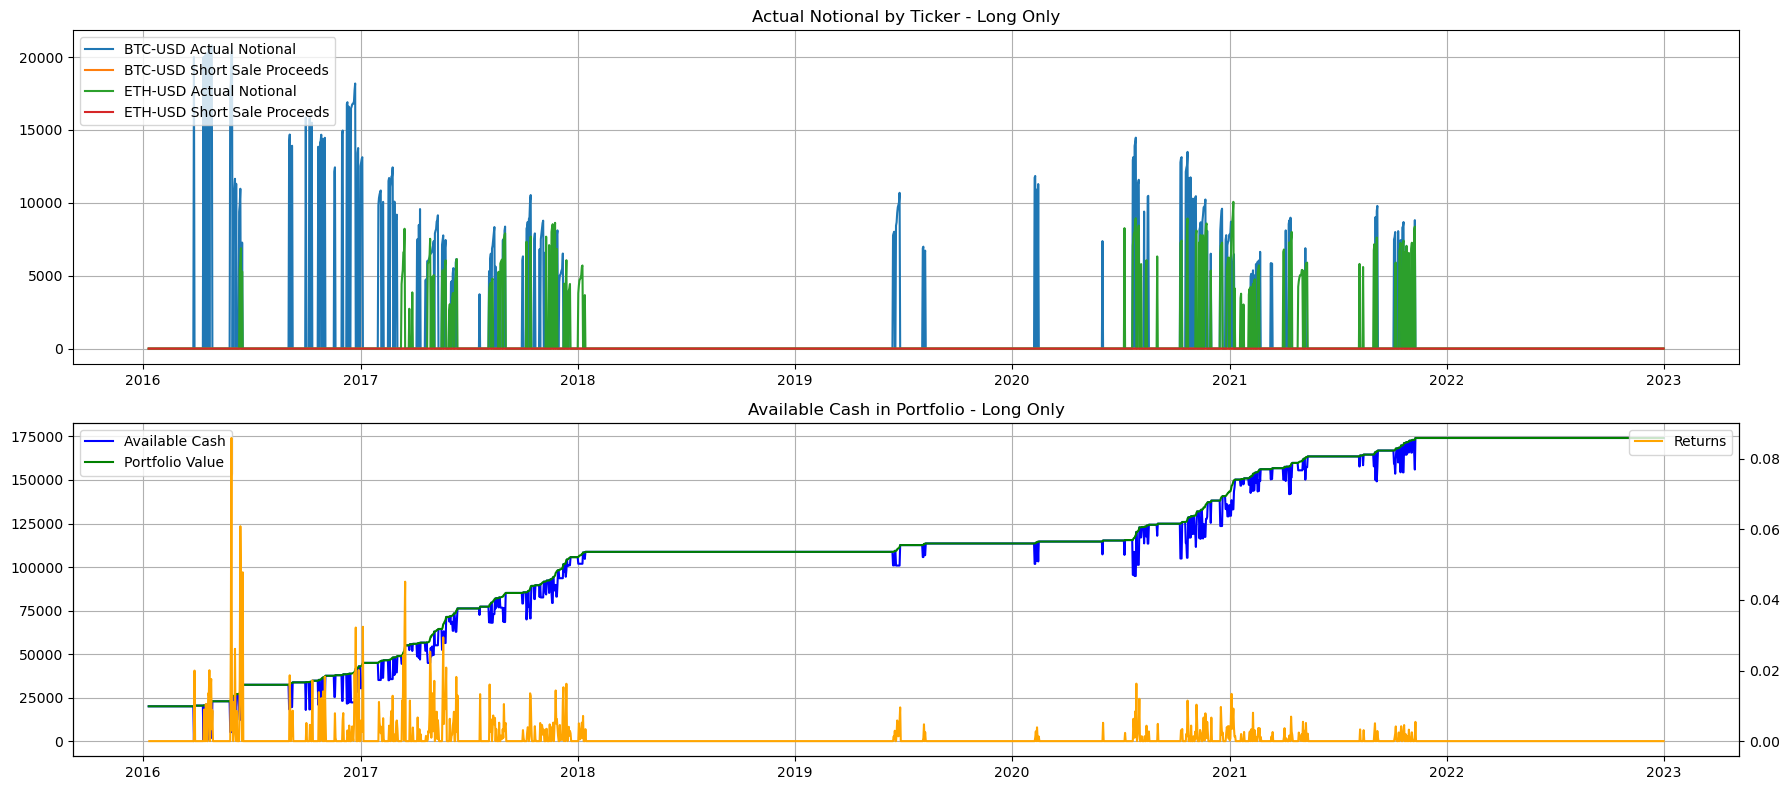

In [120]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position_long.index >= pd.Timestamp('2022-01-01').date()) & (df_position_long.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position_long.index, df_position_long[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    _ = actual_notional_ax.plot(df_position_long.index, df_position_long[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position_long.index, df_position_long[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax.plot(df_position_long.index, df_position_long[f'total_portfolio_value'], label=f'Portfolio Value', color='green')
_ = available_cash_ax2.plot(df_position_long.index, df_position_long[f'daily_pct_returns'], label=f'Returns', color='orange')
# _ = available_cash_ax.plot(df_position_long.index, df_position_long[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long Only')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long Only')

plt.tight_layout()

## Position Sizing using Annualized Standard Deviation

In [474]:
def calculate_annualized_standard_deviation(start_date, end_date, ticker, rolling_std_window, annual_trading_days=365):

    ## Get Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, end_date=end_date, save_to_file=False)
    df = (df[['close']].rename(columns={'close':ticker}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    df[f'{ticker}_t_1_close'] = df[ticker].shift(1)

    ## Calculate Annualized Standard Deviation
    df[f'{ticker}_pct_returns'] = df[f'{ticker}'].pct_change()
    df[f'{ticker}_{rolling_std_window}_std_dev'] = df[f'{ticker}_pct_returns'].rolling(window=rolling_std_window).std()
    df[f'{ticker}_{rolling_std_window}_annualized_std_dev'] = df[f'{ticker}_{rolling_std_window}_std_dev'] * np.sqrt(annual_trading_days)

    return df

In [476]:
## Position Sizing Strategy will calculate Account Risk based on risk tolerance per trade and Trade Risk based on ATR or stop loss multiple
## Position Size will be determined by dividing the Account Risk by the Trade Risk
def get_position_sizing_using_std(start_date, end_date, ticker_list, rolling_std_window, initial_capital, risk_per_trade, stop_loss_multiple,
                                 annual_trading_days=365):

    std_list = []
    for ticker in ticker_list:
        df_std = calculate_annualized_standard_deviation(start_date=start_date, end_date=end_date, ticker=ticker,
                                                         rolling_std_window=rolling_std_window, annual_trading_days=annual_trading_days)
        
        ## Calculate Target Size and Notional based on the Average True Range
        target_size_col = f'{ticker}_target_size'
        target_notional_col = f'{ticker}_target_notional'
        std_cols = [f'{ticker}_t_1_close', f'{ticker}_{rolling_std_window}_annualized_std_dev', target_size_col, target_notional_col]
        df_std[target_size_col] = (initial_capital * risk_per_trade)/(df_std[f'{ticker}_{rolling_std_window}_annualized_std_dev'] * stop_loss_multiple)
        df_std[target_notional_col] = df_std[f'{ticker}_target_size'] * df_std[f'{ticker}_t_1_close']
        std_list.append(df_std[std_cols])
        
    df_std_ticker = pd.concat(std_list, axis=1)
    
    ## Check if the sum of the target notionals for all tickers exceeds the initial capital
    df_std_ticker['scaling_factor'] = 1
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    df_std_ticker[f'total_target_notional'] = df_std_ticker[target_notional_cols].sum(axis=1)
    df_std_ticker['scaling_factor'] = np.where(df_std_ticker['total_target_notional'] > initial_capital, 
                                               initial_capital/df_std_ticker['total_target_notional'], 1)
    df_std_ticker[target_notional_cols] = (
        df_std_ticker[target_notional_cols].multiply(df_std_ticker['scaling_factor'], axis=0))
    
    df_std_ticker[f'total_target_notional'] = df_std_ticker[target_notional_cols].sum(axis=1)
    df_std_ticker['initial_capital'] = initial_capital
    
    return df_std_ticker

In [494]:
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD']#,'ADO-USD']
df_std_target_position = get_position_sizing_using_std(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_std_window=20, 
                                                       initial_capital=20000, risk_per_trade=0.02, stop_loss_multiple=1)

In [464]:
20000*0.02

400.0

In [495]:
df_std_target_position.head(200)

,BTC-USD_t_1_close,BTC-USD_20_annualized_std_dev,BTC-USD_target_size,BTC-USD_target_notional,ETH-USD_t_1_close,ETH-USD_20_annualized_std_dev,ETH-USD_target_size,ETH-USD_target_notional,SOL-USD_t_1_close,SOL-USD_20_annualized_std_dev,SOL-USD_target_size,SOL-USD_target_notional,LTC-USD_t_1_close,LTC-USD_20_annualized_std_dev,LTC-USD_target_size,LTC-USD_target_notional,scaling_factor,total_target_notional,initial_capital
date,,,,,,,,,,,,,,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-02,435.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-03,435.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-04,431.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-05,433.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-06,433.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-07,430.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-08,459.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000
2016-01-09,454.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.0,20000


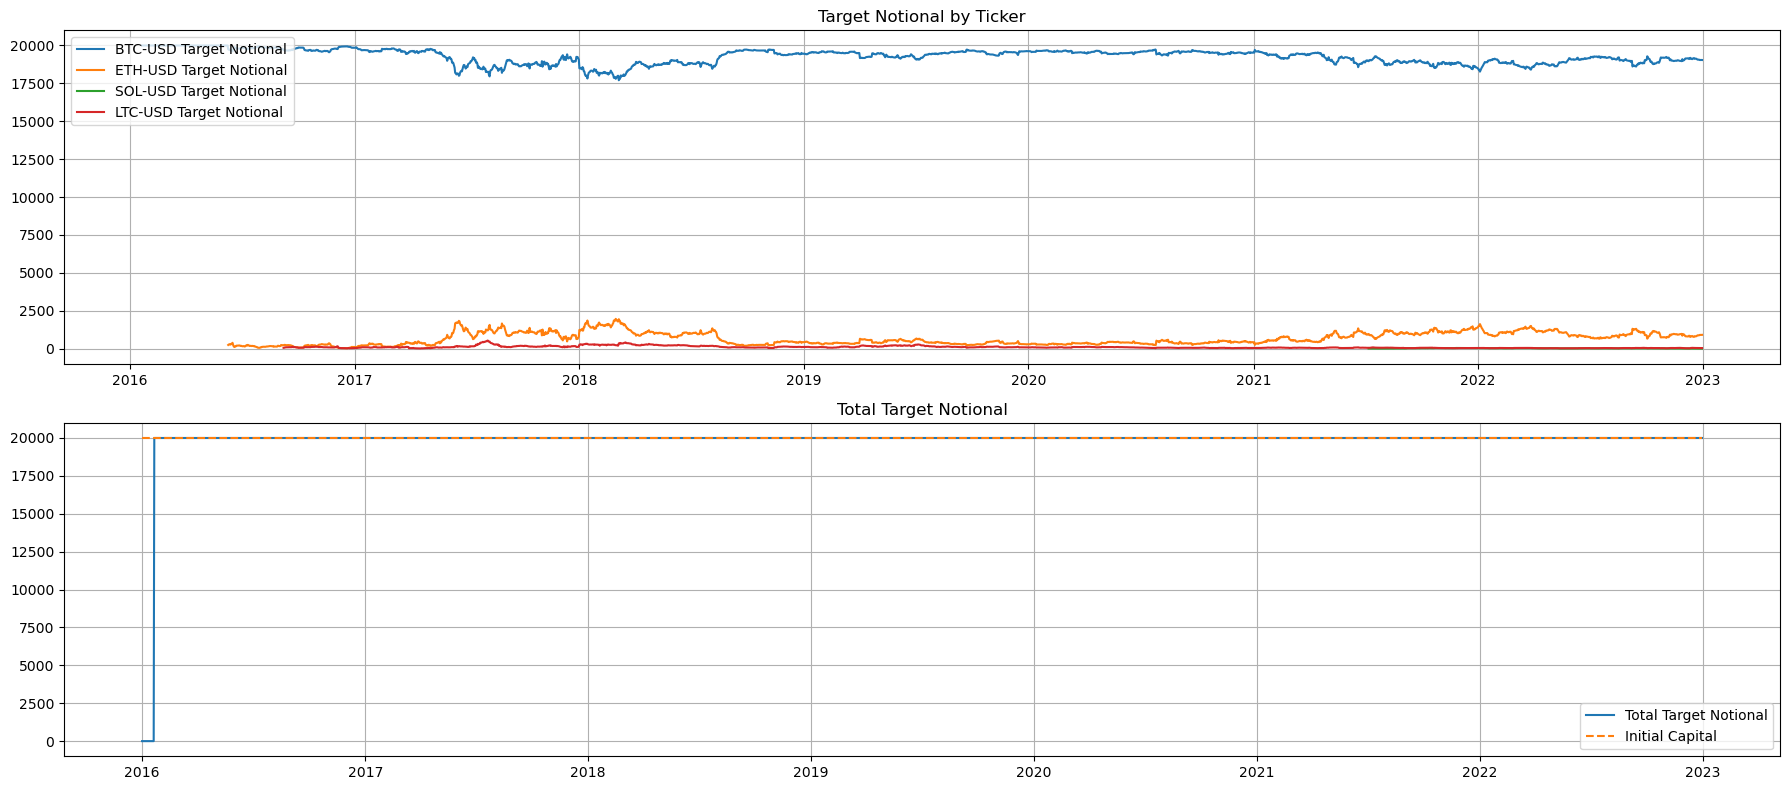

In [496]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
target_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
total_target_notional_ax = plt.subplot2grid(layout, (1,0), colspan=2)

# date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = target_notional_ax.plot(df_std_target_position.index, df_std_target_position[f'{ticker}_target_notional'], label=f'{ticker} Target Notional')
_ = total_target_notional_ax.plot(df_std_target_position.index, df_std_target_position[f'total_target_notional'], label=f'Total Target Notional')
_ = total_target_notional_ax.plot(df_std_target_position.index, df_std_target_position[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = target_notional_ax.grid()
_ = target_notional_ax.legend(loc='upper left')
_ = target_notional_ax.set_title(f'Target Notional by Ticker')

_ = total_target_notional_ax.grid()
_ = total_target_notional_ax.legend(loc='lower right')
_ = total_target_notional_ax.set_title(f'Total Target Notional')

plt.tight_layout()

In [436]:
def apply_std_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                       long_only=False, include_signal_strength=False, rolling_std_window=20, stop_loss_multiple=1, transaction_cost_est=0.001, risk_per_trade=0.05, initial_capital=15000,
                                       passive_trade_rate=0.05, use_coinbase_data=True, rolling_sharpe_window=50):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                       mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, long_only=long_only)

    ## Generate Target Position Size and Notional for all tickers
    df_target_position = get_position_sizing_using_std(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_std_window=rolling_std_window, 
                                                       initial_capital=initial_capital, risk_per_trade=risk_per_trade, stop_loss_multiple=stop_loss_multiple)

    ## Merge the Trend and Target Position Dataframes
    df = pd.merge(df_trend, df_target_position, left_index=True, right_index=True, how='left')

    ## Get Daily Positions
    df = get_daily_portfolio_positions(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window)

    ## Calculate Available Cash and Portfolio Positions
    df = get_portfolio_cash_and_market_value(df, initial_capital, ticker_list)

    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    trade_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades' for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    average_fee_per_trade = perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
    adjusted_daily_returns = df[f'portfolio_daily_pct_returns'] - (df[f'portfolio_trade_count']) * (transaction_cost_est + average_fee_per_trade)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    df['portfolio_strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col='portfolio_trade_count'))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})
    
    plot_portfolio_trend_following_performance(df, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)
    
    return df

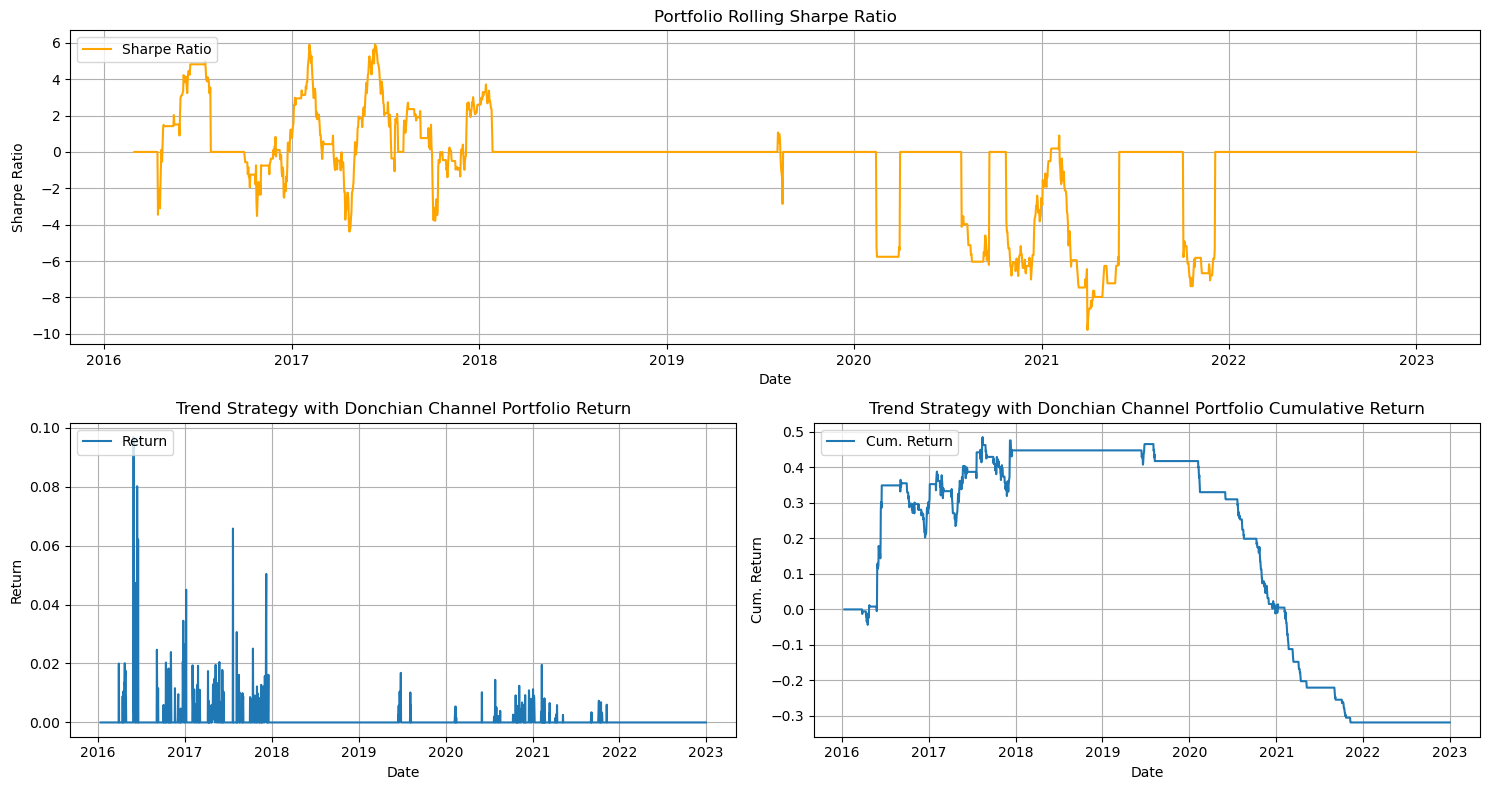

In [438]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only=True
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_long = apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                      mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                      stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only)

In [442]:
df_position_long.head(100)

,BTC-USD,BTC-USD_20_annualized_std_dev,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_event,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,scaling_factor,total_target_notional,initial_capital,available_cash,count_of_positions,total_actual_position_notional,total_portfolio_value,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11,449.19,NaN,0,-0.000000,NaN,0.00,0.00,0.000000,0.000000,NaN,0.0,449.99,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,NaN,NaN
2016-01-12,434.01,NaN,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,449.19,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-13,432.77,NaN,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,434.01,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-14,430.03,NaN,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,432.77,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-15,357.53,NaN,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,430.03,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-16,388.70,NaN,0,0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,357.53,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-17,378.46,NaN,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,388.70,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-18,384.89,NaN,0,0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,378.46,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN
2016-01-19,375.27,NaN,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,No Event,0.0,384.89,NaN,NaN,1.000000,0.0,20000,20000.000000,0.0,0.000000,20000.000000,0.000000,0.0,0.000000,NaN


In [ ]:
df_target_position = get_position_sizing_using_atr(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window, 
                                                       initial_capital=initial_capital, risk_per_trade=risk_per_trade, stop_loss_multiple=stop_loss_multiple)

In [ ]:
df_target_position.head(20)

In [ ]:
ord_cols = reorder_columns_by_ticker(df_position.columns, ticker_list)
ord_cols.extend(['scaling_factor','total_target_notional','initial_capital'])
df_position.columns = ord_cols

In [ ]:
ord_cols

In [ ]:
df_position.columns.tolist()

In [ ]:
ticker_list = ['BTC-USD','ETH-USD']
rolling_atr_window = 20
risk_per_trade = 0.02
stop_loss_multiple = 1
initial_capital = 20000
atr_list = []
trend_list = []
for ticker in ticker_list:
    atr_cols = [f'{ticker}_{rolling_atr_window}_avg_true_range_price']
    df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, price_or_returns_calc='price', rolling_atr_window=20, use_coinbase_data=True)
    # atr_list.append(df_atr[atr_cols])
    df_trend = generate_trend_signal_with_donchian_channel(start_date=pd.to_datetime(ticker_dict[ticker]).date(), end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                           mavg_stepsize=mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc,
                                                           rolling_donchian_window=rolling_donchian_window, include_signal_strength=include_signal_strength)
    df_trend[f'{ticker}_t_1_close'] = df_trend[f'{ticker}'].shift(1)
    trend_cols = [f'{ticker}',f'{ticker}_t_1_close',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal', 
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
    df_trend = pd.merge(df_trend[trend_cols], df_atr[atr_cols], left_index=True, right_index=True, how='left')

    ## Calculate Target Size and Notional based on the Average True Range
    df_trend[f'{ticker}_atr_target_size'] = (initial_capital * risk_per_trade)/(df_trend[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] * stop_loss_multiple)
    df_trend[f'{ticker}_atr_target_notional'] = df_trend[f'{ticker}_atr_target_size'] * df_trend[f'{ticker}_t_1_close']
    trend_list.append(df_trend)
df_trend_ticker = pd.concat(trend_list, axis=1)

## Check if the sum of the target notionals for all tickers exceeds the initial capital
target_notional_cols = [f'{ticker}_atr_target_notional' for ticker in ticker_list]
df_trend_ticker[f'total_target_notional'] = df_trend_ticker[target_notional_cols].sum(axis=1)
for i in range(1, len(df_trend_ticker)):
    if df_trend_ticker['total_target_notional'][i] > initial_capital:
        scaling_factor = initial_capital/df_trend_ticker['total_target_notional'][i]
        df_trend_ticker[target_notional_cols] = df_trend_ticker[target_notional_cols] * scaling_factor

In [ ]:
df_trend_ticker.head()

In [ ]:
df_trend.head()

In [ ]:
trend_list = []
for ticker in ticker_list:
    df_trend = generate_trend_signal_with_donchian_channel(start_date=pd.to_datetime(ticker_dict[ticker]).date(), end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                   mavg_stepsize=mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc,
                                                                   rolling_donchian_window=rolling_donchian_window, include_signal_strength=include_signal_strength)
    trend_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
    trend_list.append(df_trend[trend_cols])

df_trend_ticker = pd.concat(trend_list, axis=1)

In [ ]:
df_trend_ticker.tail(20)

In [ ]:
df_atr_ticker.head()

In [ ]:
df_atr.head()

In [ ]:
df_atr_ticker.head()

In [ ]:
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=20,
                                     use_coinbase_data=True)

In [ ]:
df_atr.head()

In [ ]:
ticker = 'BTC-USD'
rolling_atr_window = 20
df_atr[[f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1).head()

In [ ]:
df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, 
                                                       mavg_stepsize=6, rolling_donchian_window=20, price_or_returns_calc='price', long_only=False, include_signal_strength=False)

In [ ]:
trend_cols = ['BTC-USD','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']
df_returns = df_trend[trend_cols]
# df_returns = pd.merge(df_returns, df_atr, left_index=True, right_index=True, how='left')

In [ ]:
def get_volatility_scaled_target_position_size(start_date, end_date, ticker, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                               position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, high_volatility_threshold=1.5,
                                               use_coinbase_data=True, price_or_returns_calc='price'):
    ## Calculate the Average True Range
    df = calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc, position_size_rolling_atr_window, use_coinbase_data)
    df = df[[f'{ticker}_close', f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price']].shift(1)

    ## Calculate Annualized Standard Deviation
    df[f'{ticker}_pct_returns'] = df[f'{ticker}_close'].pct_change()
    df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()
    
    # Annualize the standard deviation
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)
    
    # Shift to avoid lookahead bias
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

    ## Determine if the Volatility Regime is High or Low
    df[f'{ticker}_volatility_regime'] = np.where((df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] > high_volatility_threshold *
                                                  df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'].rolling(window=50).mean()), 'High', 'Low')
    df[f'{ticker}_volatility_regime'] = df[f'{ticker}_volatility_regime'].shift(1)

    ## Calculate Volatility Scaled Target Position
    if position_size_with_atr:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
        # df[f'{ticker}_atr_target_position_notional'] = np.where(df[f'{ticker}_volatility_regime'] == 'High', df[f'{ticker}_atr_target_position_notional'] * 0.5, df[f'{ticker}_atr_target_position_notional'])
    else:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)
        
    ## Cap position size to not exceed initial capital
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].fillna(0)
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].clip(upper=initial_capital)

    ## Shift position sizes by 1 to avoid lookahead bias
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].shift(1)
    
    return df

In [ ]:
rolling_atr_window=10
ticker = 'BTC-USD'
initial_capital = 15000
risk_per_trade = 0.2

## Calculate the Average True Range
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=rolling_atr_window,
                                     use_coinbase_data=True)
df_atr = df_atr[[f'{ticker}_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1)

## Calculate Annualized Standard Deviation
df_atr[f'{ticker}_pct_returns'] = df_atr[f'{ticker}_close'].pct_change()
position_size_rolling_atr_window = 10
position_size_atr_multiplier = 0.05
position_size_rolling_std_window = 20
position_size_std_multiplier = 10
df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df_atr[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()

# Annualize the standard deviation
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)

# Shift to avoid lookahead bias
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
# df_atr[f'{ticker}_atr_target_position_notional'] = np.where(df_atr[f'{ticker}_volatility_regime'] == 'High', df_atr[f'{ticker}_atr_target_position_notional'] * 0.5, df_atr[f'{ticker}_atr_target_position_notional'])
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)

df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].clip(upper=initial_capital)
df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].shift(1)

df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].clip(upper=initial_capital)
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].shift(1)

In [ ]:
df_atr.head(50)

In [ ]:
fig = plt.figure(figsize=(18,10))
layout = (3,2)
price_ax = plt.subplot2grid(layout, (0,0), colspan=2)
strategy_vol_ax = plt.subplot2grid(layout, (1,0), colspan=2)
strategy_vol_ax2 = strategy_vol_ax.twinx()
strategy_target_position_ax = plt.subplot2grid(layout, (2,0), colspan=2)
strategy_target_position_ax2 = strategy_target_position_ax.twinx()

date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
df_atr_trim = df_atr[date_cond]
_ = price_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='orange')
_ = strategy_vol_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='blue')
_ = strategy_vol_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
_ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_atr_vol_scaled_target_notional'], label=f'{ticker} ATR Target Notional', color='red')
_ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_std_vol_scaled_target_notional'], label=f'{ticker} STD Target Notional', color='green')
_ = strategy_target_position_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='blue', linestyle='--')
# _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'{ticker} Price')

_ = strategy_vol_ax.grid()
_ = strategy_vol_ax.legend(loc='upper left')
_ = strategy_vol_ax2.legend(loc='upper right')
_ = strategy_vol_ax.set_title(f'{ticker} Average True Range & Annualized Volatility')

_ = strategy_target_position_ax.grid()
_ = strategy_target_position_ax.legend(loc='upper left')
_ = strategy_target_position_ax2.legend(loc='upper right')
_ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15,6))
layout = (1,1)
price_ax = plt.subplot2grid(layout, (0,0), colspan=2)
price_ax2 = price_ax.twinx()
# strategy_vol_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# strategy_vol_ax2 = strategy_vol_ax.twinx()
# strategy_target_position_ax = plt.subplot2grid(layout, (2,0), colspan=2)
# strategy_target_position_ax2 = strategy_target_position_ax.twinx()

date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
df_atr_trim = df_atr[date_cond]
_ = price_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='orange')
_ = price_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
# _ = strategy_vol_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='blue')
# _ = strategy_vol_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
# _ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_atr_vol_scaled_target_notional'], label=f'{ticker} ATR Target Notional', color='red')
# _ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_std_vol_scaled_target_notional'], label=f'{ticker} STD Target Notional', color='green')
# _ = strategy_target_position_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='blue', linestyle='--')
# _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'{ticker} Price')

# _ = strategy_vol_ax.grid()
# _ = strategy_vol_ax.legend(loc='upper left')
# _ = strategy_vol_ax2.legend(loc='upper right')
# _ = strategy_vol_ax.set_title(f'{ticker} Average True Range & Annualized Volatility')

# _ = strategy_target_position_ax.grid()
# _ = strategy_target_position_ax.legend(loc='upper left')
# _ = strategy_target_position_ax2.legend(loc='upper right')
# _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

plt.tight_layout()

In [ ]:
df_atr[[f'{ticker}_close', f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price', f'{ticker}_{position_size_rolling_std_window}_annualized_volatility']].corr()

In [ ]:
df_atr[[f'{ticker}_close', f'{ticker}_atr_vol_scaled_target_notional', f'{ticker}_std_vol_scaled_target_notional']].corr()

In [ ]:
def apply_vol_adjusted_position_sizing_strategy(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                                long_only=False, include_signal_strength=False, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                                position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, use_coinbase_data=True,
                                                high_volatility_threshold=1.5, stop_loss_multiplier=1.5, take_profit_multiplier=3, apply_position_sizing_pyramid=True, position_sizing_pyramid_factor=0.5):

    close_price_col = f'{ticker}'
    t_1_close_price_col = f'{ticker}_t_1'
    signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
    target_position_notional_col = f'{ticker}_vol_scaled_target_notional'
    actual_position_notional_col = f'{ticker}_actual_position_notional'
    actual_position_shares_col = f'{ticker}_actual_position_share_count'
    actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
    atr_col = f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'
    std_col = f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'
    
    df = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                     long_only=long_only, include_signal_strength=include_signal_strength)
    trend_cols = [close_price_col, signal_col, returns_col, trades_col]
    df = df[trend_cols]
    df[t_1_close_price_col] = df[close_price_col].shift(1)
    
    df_position = get_volatility_scaled_target_position_size(start_date=start_date, end_date=end_date, ticker=ticker, position_size_with_atr=position_size_with_atr, 
                                                             position_size_rolling_atr_window=position_size_rolling_atr_window, position_size_atr_multiplier=position_size_atr_multiplier,
                                                             position_size_rolling_std_window=position_size_rolling_std_window, position_size_std_multiplier=position_size_std_multiplier,
                                                             risk_per_trade=risk_per_trade, initial_capital=initial_capital, high_volatility_threshold=high_volatility_threshold,
                                                             use_coinbase_data=use_coinbase_data, price_or_returns_calc=price_or_returns_calc)
    df = pd.merge(df, df_position, left_index=True, right_index=True, how='left')

    if apply_position_sizing_pyramid:
        ## Apply Position Sizing Pyramid Factor
        df[target_position_notional_col] = np.where((df[signal_col] == 1) | (df[signal_col] == -1), df[target_position_notional_col] * (1 + position_sizing_pyramid_factor),
                                                    df[target_position_notional_col])
    df[actual_position_notional_col] = 0.0
    df[actual_position_entry_price_col] = 0.0
    df[actual_position_shares_col] = 0.0
    df['portfolio_value'] = initial_capital
    df['event'] = np.nan
    
    position = 0
    entry_price = None
    
    for i in range(1, len(df)):
        ## Taking a New Long position
        if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Long Position: {df.index[i]}')
            # position = df[position_col][i]
            # entry_price = df[close_price_col][i]
            # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
            # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Long Position'
            
        ## Taking a New Short position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Short Position'
            
        ## Amending an Existing Long Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Amending an Existing Long Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Long Position'
            # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
            
        ## Amending an Existing Short Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Amending an Existing Short Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Short Position'
            
        ## Taking a New Long Position with an Existing Short Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Take a New Long Position with an Existing Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Long with Existing Short Position'
            
        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Take a New Short Position with an Existing Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Short with Existing Long Position'
        
        ## Closing a Long Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Closing a Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i]
            df['event'][i] = 'Closing Long Position'
            
        ## Closing a Short Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Closing a Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + (df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i])
            df['event'][i] = 'Closing Short Position'
    
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
            # print(f'Other: {df_test.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'No Event'
        
        
            
        # elif df[signal_col][i] == -1 and position > 0:
        #     initial_capital += position * (df[close_price_col][i] - entry_price)
        #     position = 0
        #     entry_price = None
        
        # # Stop-loss and take-profit logic
        # if position > 0:
        #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
        #         initial_capital += position * (df[close_price_col][i] - entry_price)
        #         position = 0
        #         entry_price = None
        
        # df.at[df.index[i], 'Capital'] = initial_capital

    return df

In [ ]:
df_strategy_atr = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                              rolling_donchian_window=20, position_size_with_atr=True, position_size_atr_multiplier=0.05)
df_strategy_std = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                              rolling_donchian_window=20, position_size_with_atr=False, position_size_std_multiplier=10)

In [ ]:
print(df_strategy_atr.shape)
print(df_strategy_std.shape)

In [ ]:
ticker

In [ ]:
df_strategy_atr.head()

In [ ]:
## TODO: Fix the below code, this doesn't work
def apply_pyramiding(df, ticker, position_col, atr_col, close_col, rolling_atr_window, add_position_atr_multiplier, max_pyramid_levels=3, risk_per_trade=0.05, initial_capital=15000):
    """
    Adjusts the target position by adding to the base position incrementally during a confirmed trend.
    
    Parameters:
    - df: DataFrame containing the price and ATR data.
    - ticker: Ticker symbol.
    - base_position_size: Initial position size.
    - atr_window: Number of periods for ATR calculation.
    - atr_multiplier: ATR-based threshold for adding positions.
    - max_pyramid_levels: Maximum number of incremental adds allowed.
    - risk_per_trade: Risk percentage for each add.
    
    Returns:
    - df with adjusted target positions considering pyramiding.
    """
    # df['current_position'] = base_position_size
    for level in range(1, max_pyramid_levels + 1):
        add_threshold = level * add_position_atr_multiplier * df[f'{ticker}_{rolling_atr_window}_avg_true_range_price']
        df[f'add_level_{level}'] = np.where(
            df[close_col].shift(1) > df[close_col].shift(1).cummax() + add_threshold, 
            df[position_col] * (1 + (level * risk_per_trade)),
            0
        )
        df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[position_col] + df[f'add_level_{level}']

    df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'].clip(upper=initial_capital)
    
    return df

In [ ]:
df_strategy_atr_pyramid = apply_pyramiding(df_strategy_atr, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', close_col=f'{ticker}',
                                           rolling_atr_window=20, add_position_atr_multiplier=2)

In [ ]:
df_strategy_atr_pyramid.head(500)

In [ ]:
df_strategy_atr_pyramid[df_strategy_atr_pyramid.add_level_2 != 0].head()

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=True, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.01, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [ ]:
df_position[['DOGE-USD_20_avg_true_range_price','DOGE-USD_pct_returns']].corr()

In [ ]:
df_position.head()

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=False, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.05, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price',
    # rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_annualized_volatility'], label=f'{ticker} Annualized Vol', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Annualized Volatility')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [ ]:
def get_portfolio_performance(df_strategy, ticker, rolling_sharpe_window=50, annual_trading_days=252, annual_rf=0.05):

    short_position_event_list = ['New Short Position', 'Existing Short Position']
    df_strategy['portfolio_value_adj'] = np.where(df_strategy['event'].isin(short_position_event_list),
                                                  df_strategy['portfolio_value'] + (df_strategy[f'{ticker}_actual_position_share_count'] * df_strategy[f'{ticker}_actual_position_entry_price']),
                                                  df_strategy['portfolio_value'])
    df_strategy['strategy_pct_returns'] = df_strategy['portfolio_value_adj'].pct_change()
    
    # Calculate rolling mean and standard deviation for 50-day intervals
    rolling_mean = df_strategy['strategy_pct_returns'].rolling(window=rolling_sharpe_window).mean()
    rolling_std = df_strategy['strategy_pct_returns'].rolling(window=rolling_sharpe_window).std()
    
    # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
    df_strategy[f'{ticker}_rolling_sharpe_ratio_{rolling_sharpe_window}d'] = (rolling_mean - annual_rf)/rolling_std

    # Overall Sharpe Ratio
    average_daily_return = df_strategy['strategy_pct_returns'].mean()
    average_daily_std = df_strategy['strategy_pct_returns'].std()
    daily_rf = (1 + annual_rf) ** (1/annual_trading_days) - 1
    daily_sharpe_ratio = (average_daily_return - daily_rf) / average_daily_std
    annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(annual_trading_days)
    print("Overall Annualized Sharpe Ratio:", annualized_sharpe_ratio)

    return df_strategy    

In [ ]:
df_strategy_atr.head()

In [ ]:
df_strategy_atr = get_portfolio_performance(df_strategy_atr, ticker='BTC-USD', rolling_sharpe_window=50, annual_trading_days=365)
df_strategy_std = get_portfolio_performance(df_strategy_std, ticker='BTC-USD', rolling_sharpe_window=50, annual_trading_days=365)

In [ ]:
# short_position_event_list = ['New Short Position', 'Existing Short Position']
# df_strategy_atr['portfolio_value_adj'] = np.where(df_strategy_atr['event'].isin(short_position_event_list),
#                                               df_strategy_atr['portfolio_value'] + (df_strategy_atr[f'{ticker}_actual_position_share_count'] * df_strategy_atr[f'{ticker}_actual_position_entry_price']),
#                                               df_strategy_atr['portfolio_value'])
# df_strategy_atr['strategy_pct_returns'] = df_strategy_atr['portfolio_value_adj'].pct_change()

# # Calculate rolling mean and standard deviation for 50-day intervals
# rolling_mean = df_strategy_atr['strategy_pct_returns'].rolling(window=50).mean()
# rolling_std = df_strategy_atr['strategy_pct_returns'].rolling(window=50).std()

# # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
# df_strategy_atr[f'{ticker}_rolling_sharpe_ratio_50d'] = (rolling_mean * np.sqrt(annualization_factor))

In [ ]:
# Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
annualization_factor = 365  # number of trading days in a year
sharpe_ratio = (df_strategy_atr['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy_atr['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
print("Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
df_strategy_atr.head()

In [ ]:
position_size_rolling_atr_window = 20
all_ticker_non_pyramid_atr_df = {}
for ticker in ticker_list:
    print(ticker)
    df_strategy_atr = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20,
                                                     position_size_rolling_atr_window=position_size_rolling_atr_window, position_size_atr_multiplier=0.05, risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    df_strategy_atr = get_portfolio_performance(df_strategy_atr, ticker=ticker, rolling_sharpe_window=50, annual_trading_days=365)

    df_strategy_atr = df_strategy_atr[df_strategy_atr.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_atr_df[ticker] = df_strategy_atr
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Average True Range Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy_atr['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy_atr['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
all_ticker_non_pyramid_std_df = {}
for ticker in ticker_list:
    print(ticker)
    df_strategy_std = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, position_size_with_atr=False,
                                                                  position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    df_strategy_std = get_portfolio_performance(df_strategy_std, ticker=ticker, rolling_sharpe_window=50, annual_trading_days=365)
    
    df_strategy_std = df_strategy_std[df_strategy_std.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_std_df[ticker] = df_strategy_std
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} Annualized Volatility', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy_std.index, df_strategy_std[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

## Position Sizing using a Target Volatility Strategy

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD','DOGE-USD']

## Strategy Parameters
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20

## Volatility Parameters
volatility_window = 20
annual_trading_days = 365

## Initial Capital
initial_capital = 15000

In [ ]:
# Function to calculate portfolio volatility
def calculate_portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

def get_target_volatility_position_sizing(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, volatility_window, annual_trading_days,
                                          rolling_cov_window, annualized_target_volatility, price_or_returns_calc='price', long_only=False, include_signal_strength=False):

    ## Generate trend signal for each ticker in the portfolio
    ticker_signal_dict = {}
    for ticker in ticker_list:
        df_trend = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                               rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                                                               include_signal_strength=include_signal_strength)

        ## Calculate Position Volatility Adjusted Trend Signal
        df_trend = tf.get_returns_volatility(df_trend, vol_range_list=[volatility_window], close_px_col=f'{ticker}')
        df_trend[f'{ticker}_annualized_volatility_{volatility_window}'] = df_trend[f'{ticker}_volatility_{volatility_window}'] * np.sqrt(annual_trading_days)
        df_trend[f'{ticker}_vol_normalized_trend_signal'] = (df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal']/
                                                             df_trend[f'{ticker}_annualized_volatility_{volatility_window}'])
        df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_vol_normalized_trend_signal'].fillna(0)
        trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                      f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
        ticker_signal_dict[ticker] = df_trend[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)
    
    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    cols = []
    for ticker in ticker_list:
        trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                      f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
        cols.append(trend_cols)
    cols = [item for sublist in cols for item in sublist]
    df_signal.columns = cols

    ## Normalize the weights of each position by the total weight of the portfolio
    vol_normalized_signal_cols = [f'{ticker}_vol_normalized_trend_signal' for ticker in ticker_list]
    df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
    for ticker in ticker_list:
        df_signal[f'{ticker}_position_volatility_normalized_weight'] = df_signal[f'{ticker}_vol_normalized_trend_signal']/df_signal[vol_normalized_signal_cols].abs().sum(axis=1)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
    cov_matrix = df_signal[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility/np.sqrt(annual_trading_days)
    
    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_position_volatility_normalized_weight' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    price_cols = [f'{ticker}_close' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
    portfolio_cols = []
    portfolio_cols.extend(scaled_weight_cols)
    df_scaled_weights = pd.DataFrame(index=df_signal.index, columns=portfolio_cols)

    ## Iterate through each day and calculate the covariance matrix, portfolio volatility and scaling factors
    for date in df_signal.index:
        if date in cov_matrix.index.get_level_values(0):
            daily_weights = df_signal[unscaled_weight_cols].loc[date].values
            daily_cov_matrix = cov_matrix.loc[date].values
            portfolio_volatility = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
            
            # Scale the weights to target volatility
            scaling_factor = daily_target_volatility / portfolio_volatility
            df_scaled_weights.loc[date][scaled_weight_cols] = daily_weights * scaling_factor

    ## Delete rows prior to the first available date of the covariance matrix
    df_scaled_weights = df_scaled_weights[df_scaled_weights.index >= cov_matrix.index[0][0]]
    
    return df_scaled_weights

In [ ]:
vol_normalized_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
df_scaled_weights['sum_of_weights'] = df_scaled_weights[df_scaled_weights.columns].sum(axis=1)

In [ ]:
df_scaled_weights[np.abs(df_scaled_weights.sum_of_weights) > 1]

In [ ]:
target_position_value_cols = [f'{ticker}_target_position_value' for ticker in ticker_list]
target_position_value_cols.extend(['total_target_position_value'])
df_position[df_position.total_target_position_value > 15000][target_position_value_cols]

In [ ]:
df_position[vol_normalized_signal_cols].head()

In [ ]:
df_position.head()

In [ ]:
def target_volatility_based_position_sizes(start_date, end_date, ticker_list, volatility_window, annual_trading_days, rolling_cov_window, annualized_target_volatility):
    
    price_dict - {}
    for ticker in ticker_list:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, 
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        price_dict[ticker] = df
    df_price = pd.concat(price_dict, axis=1)
    df_price.columns = df_price.columns.droplevel(level=0)
    for ticker in ticker_list:
        df_price = tf.get_returns_volatility(df_price, vol_range_list=[20], close_px_col=ticker)
        df_price[f'{ticker}_volatility_20'] 

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
price_dict = {}
for ticker in ticker_list:
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=start_date, 
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close']].rename(columns={'close':ticker}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    price_dict[ticker] = df
df_price = pd.concat(price_dict, axis=1)
df_price.columns = df_price.columns.droplevel(level=0)
for ticker in ticker_list:
    df_price = tf.get_returns_volatility(df_price, vol_range_list=[20], close_px_col=ticker)

In [ ]:
for ticker in ticker_list:
        df_price = tf.get_returns_volatility(df_price, vol_range_list=[20], close_px_col=ticker)

In [ ]:
df_price.head()

In [ ]:
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'LTC-USD', 'DOGE-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.60
long_only = False
initial_capital = 15000

df_scaled_weights = get_target_volatility_position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list,
                                                          fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                                                          volatility_window=volatility_window, annual_trading_days=annual_trading_days, rolling_cov_window=rolling_cov_window,
                                                          annualized_target_volatility=annualized_target_volatility, long_only=long_only)

In [ ]:
trend_dict = {}
for ticker in ticker_list:
    df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                           rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=long_only, include_signal_strength=False)
    df_trend[f'{ticker}_t_1_close'] = df_trend[f'{ticker}'].shift(1)
    trend_cols = [f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal']
    trend_dict[ticker] = df_trend[trend_cols]
df_signal = pd.concat(trend_dict, axis=1)
df_signal = df_signal.droplevel(0, axis=1)

In [ ]:
df_position = pd.merge(df_scaled_weights, df_signal, left_index=True, right_index=True, how='left')
position_cols = []
for ticker in ticker_list:
    position_cols.extend([f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',f'{ticker}_target_vol_normalized_weight'])

df_position = df_position[position_cols]
for ticker in ticker_list:
    df_position[f'{ticker}_target_position_value'] = df_position[f'{ticker}_target_vol_normalized_weight'] * initial_capital
    df_position[f'{ticker}_position_share_count'] = df_position[f'{ticker}_target_position_value']/df_position[f'{ticker}_t_1_close']

target_position_value_cols = [f'{ticker}_target_position_value' for ticker in ticker_list]
df_position['total_target_position_value'] = df_position[target_position_value_cols].sum(axis=1)

In [ ]:
df_position.head()

In [ ]:
df_position['total_target_position_value'].plot()

In [ ]:
df_trend.head()

In [ ]:
def apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, volatility_window, rolling_cov_window, annual_trading_days,
                                                     annualized_target_volatility, initial_capital, price_or_returns_calc='price', long_only=False, include_signal_strength=False):

    df_scaled_weights = get_target_volatility_position_sizing(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                              rolling_donchian_window=rolling_donchian_window, volatility_window=volatility_window, annual_trading_days=annual_trading_days,
                                                              rolling_cov_window=rolling_cov_window, annualized_target_volatility=annualized_target_volatility)

    trend_dict = {}
    for ticker in ticker_list:
        df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                               rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
        df_trend[f'{ticker}_t_1_close'] = df_trend[f'{ticker}'].shift(1)
        trend_cols = [f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_pct_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
        trend_dict[ticker] = df_trend[trend_cols]
    df_signal = pd.concat(trend_dict, axis=1)
    df_signal = df_signal.droplevel(0, axis=1)

    df_position = pd.merge(df_scaled_weights, df_signal, left_index=True, right_index=True, how='left')
    position_cols = []
    for ticker in ticker_list:
        position_cols.extend([f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_pct_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                              f'{ticker}_target_vol_normalized_weight'])
    
    df_position = df_position[position_cols]
    for ticker in ticker_list:
        df_position[f'{ticker}_target_position_value'] = df_position[f'{ticker}_target_vol_normalized_weight'] * initial_capital
        df_position[f'{ticker}_target_position_share_count'] = df_position[f'{ticker}_target_position_value']/df_position[f'{ticker}_t_1_close']
    
    target_position_value_cols = [f'{ticker}_target_position_value' for ticker in ticker_list]
    df_position['total_target_position_value'] = df_position[target_position_value_cols].sum(axis=1)
    # df_position['portfolio_value'] = initial_capital
    
    position = 0
    entry_price = None
    for ticker in ticker_list:
        close_price_col = f'{ticker}'
        t_1_close_price_col = f'{ticker}_t_1_close'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        target_position_notional_col = f'{ticker}_target_position_value'
        actual_position_notional_col = f'{ticker}_actual_position_value'
        actual_position_shares_col = f'{ticker}_actual_position_share_count'
        actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
        event_col = f'{ticker}_event'
        # atr_col = f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'
        # std_col = f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'

        df_position[actual_position_notional_col] = 0.0
        df_position[actual_position_entry_price_col] = 0.0
        df_position[actual_position_shares_col] = 0.0
        df_position[event_col] = np.nan
        
        for i in range(1, len(df_position)):
            ## Taking a New Long position
            if (df_position[signal_col][i] == 1) and (df_position[signal_col][i-1] == 0) and (df_position[actual_position_notional_col][i-1] == 0):
                # print(f'Take a New Long Position: {df_position.index[i]}')
                # position = df[position_col][i]
                # entry_price = df[close_price_col][i]
                # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
                # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
                df_position[actual_position_notional_col][i] = df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - df_position[actual_position_notional_col][i]
                df_position[event_col][i] = 'New Long Position'
                
            ## Taking a New Short position
            elif (df_position[signal_col][i] == -1) and (df_position[signal_col][i-1] == 0) and (df_position[actual_position_notional_col][i-1] == 0):
                # print(f'Take a New Short Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = -df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - df_position[actual_position_notional_col][i]
                df_position[event_col][i] = 'New Short Position'
                
            ## Amending an Existing Long Position
            elif (df_position[signal_col][i] == 1) and (df_position[signal_col][i-1] == 1) and (df_position[actual_position_notional_col][i-1] > 0):
                # print(f'Amending an Existing Long Position: {df_position.index[i]}')
                df_position[actual_position_shares_col][i] = df_position[actual_position_shares_col][i-1]
                df_position[actual_position_notional_col][i] = df_position[actual_position_shares_col][i] * df_position[t_1_close_price_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[actual_position_entry_price_col][i-1]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1]
                df_position[event_col][i] = 'Existing Long Position'
                # df_position['initial_capital'][i] = df_position['initial_capital'][i] + (df_position[actual_position_notional_col][i] - df_position[actual_position_notional_col][i-1])
                
            ## Amending an Existing Short Position
            elif (df_position[signal_col][i] == -1) and (df_position[signal_col][i-1] == -1) and (df_position[actual_position_notional_col][i-1] < 0):
                # print(f'Amending an Existing Short Position: {df_position.index[i]}')
                df_position[actual_position_shares_col][i] = df_position[actual_position_shares_col][i-1]
                df_position[actual_position_notional_col][i] = df_position[actual_position_shares_col][i] * df_position[t_1_close_price_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[actual_position_entry_price_col][i-1]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1]
                df_position[event_col][i] = 'Existing Short Position'
                
            ## Taking a New Long Position with an Existing Short Position
            elif (df_position[signal_col][i] == 1) and (df_position[signal_col][i-1] == -1) and (df_position[actual_position_notional_col][i-1] < 0):
                # print(f'Take a New Long Position with an Existing Short Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - (df_position[actual_position_notional_col][i-1] + df_position[actual_position_notional_col][i])
                df_position[event_col][i] = 'New Long with Existing Short Position'
                
            ## Taking a New Short Position with an Existing Long Position
            elif (df_position[signal_col][i] == -1) and (df_position[signal_col][i-1] == 1) and (df_position[actual_position_notional_col][i-1] > 0):
                # print(f'Take a New Short Position with an Existing Long Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = -df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - (df_position[actual_position_notional_col][i-1] + df_position[actual_position_notional_col][i])
                df_position[event_col][i] = 'New Short with Existing Long Position'
            
            ## Closing a Long Position
            elif (df_position[signal_col][i] == 0) and (df_position[signal_col][i-1] == 1) and (df_position[actual_position_notional_col][i-1] > 0):
                # print(f'Closing a Long Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = 0
                df_position[actual_position_entry_price_col][i] = 0
                df_position[actual_position_shares_col][i] = 0
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] + df_position[actual_position_shares_col][i-1] * df_position[t_1_close_price_col][i]
                df_position[event_col][i] = 'Closing Long Position'
                
            ## Closing a Short Position
            elif (df_position[signal_col][i] == 0) and (df_position[signal_col][i-1] == -1) and (df_position[actual_position_notional_col][i-1] < 0):
                # print(f'Closing a Short Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = 0
                df_position[actual_position_entry_price_col][i] = 0
                df_position[actual_position_shares_col][i] = 0
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] + (df_position[actual_position_shares_col][i-1] * df_position[t_1_close_price_col][i])
                df_position[event_col][i] = 'Closing Short Position'
        
            elif (df_position[signal_col][i] == 0) and (df_position[signal_col][i-1] == 0):
                # print(f'Other: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = 0
                df_position[actual_position_entry_price_col][i] = 0
                df_position[actual_position_shares_col][i] = 0
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1]
                df_position[event_col][i] = 'No Position'
            
            # elif df[signal_col][i] == -1 and position > 0:
            #     initial_capital += position * (df[close_price_col][i] - entry_price)
            #     position = 0
            #     entry_price = None
            
            # # Stop-loss and take-profit logic
            # if position > 0:
            #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
            #         initial_capital += position * (df[close_price_col][i] - entry_price)
            #         position = 0
            #         entry_price = None
            
            # df.at[df.index[i], 'Capital'] = initial_capital
    for ticker in ticker_list:
        df_position[f'{ticker}_actual_position_return'] = df_position[f'{ticker}_pct_returns'] * df_position[f'{ticker}_target_vol_normalized_weight']

    position_return_cols = [f'{ticker}_actual_position_return' for ticker in ticker_list]
    df_position[f'total_portfolio_return'] = df_position[position_return_cols].sum(axis=1)

    trade_cols = [f'{ticker}_50_6_250_mavg_crossover_20_donchian_strategy_trades' for ticker in ticker_list]
    df_position['total_actual_position_trades'] = np.abs(df_position[trade_cols]).sum(axis=1)
    
    actual_position_value_cols = [f'{ticker}_actual_position_value' for ticker in ticker_list]
    df_position['total_actual_position_value'] = df_position[actual_position_value_cols].sum(axis=1)

    return df_position

In [ ]:
df_position = apply_target_volatility_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                               mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, volatility_window=volatility_window,
                                                               rolling_cov_window=rolling_cov_window, annual_trading_days=annual_trading_days, annualized_target_volatility=annualized_target_volatility,
                                                               initial_capital=initial_capital, price_or_returns_calc='price', long_only=False, include_signal_strength=False)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='total_portfolio_return',
                                                                                   strategy_trade_count_col='total_actual_position_trades',
                                                                                   annual_trading_days=365, passive_trade_rate=0.005)

In [ ]:
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_pos_sizing = pd.DataFrame(columns=performance_columns)
pos_sizing_results = []
for vol in np.arange(0.05, 0.80, 0.05):
    print(vol)
    df_position = apply_target_volatility_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                   mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, volatility_window=volatility_window,
                                                                   rolling_cov_window=rolling_cov_window, annual_trading_days=annual_trading_days, annualized_target_volatility=vol,
                                                                   initial_capital=initial_capital, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
    metrics = perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='total_portfolio_return',
                                                          strategy_trade_count_col='total_actual_position_trades',
                                                          annual_trading_days=365, passive_trade_rate=0.005)
    df_pos_sizing.loc[f'position_sizing_{round(vol*100, 0)}'] = metrics
    
    # print(f'Target Volatility: {round(vol,2)}\n')
    # print(f"Performance Statistics: \n{perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='total_portfolio_return',
    #                                                                                strategy_trade_count_col='total_actual_position_trades',
    #                                                                                annual_trading_days=365, passive_trade_rate=0.005)}\n")

In [ ]:
df_pos_sizing

In [ ]:
df_position[df_position.total_actual_position_value > 30000]

In [ ]:
cols = ['BTC-USD_target_position_value','ETH-USD_target_position_value','SOL-USD_target_position_value','LTC-USD_target_position_value','DOGE-USD_target_position_value'
df_position.loc[df_position.index[45:55]]

In [ ]:
df_position.total_actual_position_value.plot()

In [ ]:
df_position.total_target_position_value.plot()

In [ ]:
cols = [col for col in df_position.columns if 'BTC' in col]
df_position[cols].head(10)

In [ ]:
cols = [col for col in df_trend.columns if 'BTC' in col]
df_trend.head()#[df_trend['DOGE-USD_50_6_250_mavg_crossover_20_donchian_signal'] != 0].tail(20)

In [ ]:
df_trend[df_trend.index.isin(df_trend.index[470:495])]

In [ ]:
df_trend[df_trend.index == pd.Timestamp('2022-10-15').date()]

In [ ]:
trade_cols = [f'{ticker}_50_6_250_mavg_crossover_20_donchian_strategy_trades' for ticker in ticker_list]

In [ ]:
df_position[trade_cols]

In [ ]:
np.abs(df_position[trade_cols]).sum(axis=1)

In [ ]:
for ticker in ticker_list:
    print(ticker)
    
    fig = plt.figure(figsize=(15,6))
    layout = (1,1)
    price_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    price_ax2 = price_ax.twinx()
    # strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    # sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = price_ax.plot(df_position.index, df_position[f'{ticker}'], label=f'{ticker} Price', color='blue')
    # _ = strategy_atr_ax2.plot(df_position.index, df_position[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = price_ax2.plot(df_position.index, df_position[f'{ticker}_target_position_value'], label=f'{ticker} Target Position', color='orange')
    # _ = sharpe_ax.plot(df_position.index, df_position[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = price_ax.grid()
    _ = price_ax.legend(loc='upper left')
    _ = price_ax2.legend(loc='upper right')
    _ = price_ax.set_title(f'{ticker} Position Size using Target Volatility')
    
    # _ = strategy_target_position_ax.grid()
    # _ = strategy_target_position_ax.legend(loc='upper left')
    # _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    # _ = sharpe_ax.grid()
    # _ = sharpe_ax.legend(loc='upper left')
    # _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
position_cols

In [ ]:
df_position.head()

In [ ]:
df_signal.head()

In [ ]:
df_scaled_weights

In [ ]:
cov_matrix.index[0][0]

In [ ]:
df_scaled_weights[df_scaled_weights.index < cov_matrix.index[0][0]].tail()

In [ ]:
ticker_signal_dict = {}
for ticker in ticker_list:
    ## Generate the Trend Signal for each position
    df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                           rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
    
    ## Calculate the Volatility Adjusted Trend Signal for each Position
    df_trend = tf.get_returns_volatility(df_trend, vol_range_list = [volatility_window], close_px_col=f'{ticker}')
    df_trend[f'{ticker}_annualized_volatility_{volatility_window}'] = df_trend[f'{ticker}_volatility_{volatility_window}'] * np.sqrt(annual_trading_days)
    df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal']/df_trend[f'{ticker}_annualized_volatility_{volatility_window}']
    df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_vol_normalized_trend_signal'].fillna(0)
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                  f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
    ticker_signal_dict[ticker] = df_trend[trend_cols]
df_signal = pd.concat(ticker_signal_dict, axis=1)

## Assign new column names to the dataframe
df_signal.columns = df_signal.columns.to_flat_index()
cols = []
for ticker in ticker_list:
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                  f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
    cols.append(trend_cols)
cols = [item for sublist in cols for item in sublist]
df_signal.columns = cols

In [ ]:
## Normalize the weights of each position by the total weight of the portfolio
vol_normalized_signal_cols = [f'{ticker}_vol_normalized_trend_signal' for ticker in ticker_list]
df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
for ticker in ticker_list:
    df_signal[f'{ticker}_position_volatility_normalized_weight'] = df_signal[f'{ticker}_vol_normalized_trend_signal']/df_signal[vol_normalized_signal_cols].abs().sum(axis=1)

In [ ]:
# Function to calculate portfolio volatility
def calculate_portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

In [ ]:
rolling_cov_window = 20
returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
cov_matrix = df_signal[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

In [ ]:
# Target portfolio volatility
annualized_target_volatility = 0.15  # Example target, e.g., 15%
daily_target_volatility = annualized_target_volatility/np.sqrt(annual_trading_days)

# Scale weights to achieve target portfolio volatility
unscaled_weight_cols = [f'{ticker}_position_volatility_normalized_weight' for ticker in ticker_list]
scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
price_cols = [f'{ticker}_close' for ticker in ticker_list]
t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
portfolio_cols = []
portfolio_cols.extend(price_cols)
portfolio_cols.extend(t_1_price_cols)
portfolio_cols.extend(unscaled_weight_cols)
portfolio_cols.extend(['daily_actual_portfolio_volatility','daily_target_portfolio_volatility','target_volatility_scaling_factor'])
portfolio_cols.extend(scaled_weight_cols)
df_scaled_weights = pd.DataFrame(index=df_signal.index, columns=portfolio_cols)
df_signal[t_1_price_cols] = df_signal[ticker_list].shift(1)

In [ ]:
df_signal[['BTC-USD','BTC-USD_t_1_close','ETH-USD','ETH-USD_t_1_close','SOL-USD','SOL-USD_t_1_close','LTC-USD','LTC-USD_t_1_close','DOGE-USD','DOGE-USD_t_1_close']].tail(20)

In [ ]:
for date in df_signal.index:
    if date in cov_matrix.index.get_level_values(0):
        daily_weights = df_signal[unscaled_weight_cols].loc[date].values
        df_scaled_weights.loc[date][unscaled_weight_cols] = daily_weights
        daily_cov_matrix = cov_matrix.loc[date].values
        portfolio_volatility = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
        df_scaled_weights.loc[date][price_cols] = df_signal.loc[date][ticker_list]
        df_scaled_weights.loc[date][t_1_price_cols] = df_signal.loc[date][t_1_price_cols]
        df_scaled_weights.loc[date]['daily_actual_portfolio_volatility'] = portfolio_volatility
        df_scaled_weights.loc[date]['daily_target_portfolio_volatility'] = daily_target_volatility
        
        # Scale the weights to target volatility
        scaling_factor = daily_target_volatility / portfolio_volatility
        df_scaled_weights.loc[date]['target_volatility_scaling_factor'] = scaling_factor
        df_scaled_weights.loc[date][scaled_weight_cols] = daily_weights * scaling_factor

In [ ]:
signal_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal' for ticker in ticker_list]
df_scaled_weights = pd.merge(df_scaled_weights, df_signal[signal_cols], left_index=True, right_index=True, how='left')
df_scaled_weights = df_scaled_weights[df_scaled_weights.index > cov_matrix.index[0][0]]
for ticker in ticker_list:
    df_scaled_weights[f'{ticker}_target_position_value'] = df_scaled_weights[f'{ticker}_target_vol_normalized_weight'] * initial_capital

In [ ]:
position_value_cols = [f'{ticker}_position_value' for ticker in ticker_list]
df_scaled_weights['position_value'] = df_scaled_weights[position_value_cols].sum(axis=1)

In [ ]:
df_scaled_weights.head(500)

In [ ]:
df_signal[signal_cols].head(200)

In [ ]:
daily_weights = df_signal[scaled_weight_cols].loc[pd.to_datetime('2022-06-16').date()].values
daily_cov_matrix = cov_matrix.loc[pd.to_datetime('2022-06-16').date()].values
portfolio_vol = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)

# Scale the weights to target volatility
scaling_factor = daily_target_volatility / portfolio_vol

In [ ]:
daily_weights

In [ ]:
daily_cov_matrix

In [ ]:
portfolio_vol

In [ ]:
scaling_factor

In [ ]:
df_signal[vol_normalized_signal_cols].abs().sum(axis=1).tail(200)

In [ ]:
df_signal.tail(200)

In [ ]:
1/1.159591

In [ ]:
df_scaled_weights.tail(1000)

In [ ]:
cov_matrix

In [ ]:
df_signal[df_signal['BTC-USD_portfolio_normalized_weight'] < 1].head(200)

In [ ]:
returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]

In [ ]:
df_signal[returns_cols].rolling(20).cov(pairwise=True).dropna()

In [ ]:
normalized_weights = signals_normalized.div(signals_normalized.abs().sum(axis=1), axis=0)

In [ ]:
df_signal.head()

In [ ]:
df_trend.head()

In [ ]:
df_test = pd.concat(ticker_signal_dict, axis=1)

In [ ]:
df_test['BTC-USD'].head()

In [ ]:
df_test.columns = df_test.columns.to_flat_index()

In [ ]:
cols = []
for ticker in ticker_list:
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
    cols.append(trend_cols)
cols = [item for sublist in cols for item in sublist]

In [ ]:
cols

In [ ]:
df_test.head()

In [ ]:
ticker = 'BTC-USD'

In [ ]:
trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
              
df_trend[trend_cols].head()

In [ ]:
df_strategy.shape

In [ ]:
df_strategy.head(20)

In [ ]:
df_strategy.tail(20)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
close_price_col = f'{ticker}'
t_1_close_price_col = f'{ticker}_t_1'
signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
target_position_notional_col = f'{ticker}_target_position_notional'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_shares_col = f'{ticker}_actual_position_share_count'
actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
initial_capital = 15000

df_test = df_strategy.copy()
# df_test = df_test.head(200)
df_test[actual_position_notional_col] = 0.0
df_test[actual_position_entry_price_col] = 0.0
df_test[actual_position_shares_col] = 0.0
df_test['initial_capital'] = initial_capital
df_test['event'] = np.nan

In [ ]:
for i in range(1, len(df_test)):
    ## Taking a New Long position
    if (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Long Position: {df_test.index[i]}')
        # position = df[position_col][i]
        # entry_price = df[close_price_col][i]
        # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
        # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Long Position'
        
    ## Taking a New Short position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Short Position'
        
    ## Amending an Existing Long Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Amending an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Long Position'
        # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
        
    ## Amending an Existing Short Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Amending an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Short Position'
        
    ## Taking a New Long Position with an Existing Short Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Take a New Long Position with an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Long with Existing Short Position'
        
    ## Taking a New Short Position with an Existing Long Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Take a New Short Position with an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Short with Existing Long Position'
    
    ## Closing a Long Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Closing a Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i]
        df_test['event'][i] = 'Closing Long Position'
        
    ## Closing a Short Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Closing a Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])
        df_test['event'][i] = 'Closing Short Position'

    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 0):
        print(f'Other: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'No Event'

In [ ]:
initial_capital = 15000
df_test['portfolio_value'] = initial_capital * (1 + df_test['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns']).cumprod()
df_test.head(1500)

In [ ]:
i = 972
df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])

In [ ]:
df_test.tail(200)

In [ ]:
df_strategy['BTC-USD_strategy_position'] = df_strategy['BTC-USD_position_size'] * df_strategy['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal']

In [ ]:
strategy_cols = ['BTC-USD', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', 'Capital', 'BTC-USD_strategy_position']

In [ ]:
trend_cols = ['BTC-USD','BTC-USD_pct_returns','BTC-USD_50_mavg','BTC-USD_90_mavg','BTC-USD_130_mavg','BTC-USD_170_mavg','BTC-USD_210_mavg','BTC-USD_250_mavg',
              'BTC-USD_trend_signal','BTC-USD_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']

In [ ]:
sorted(df_trend.columns)

In [ ]:
df_trend[trend_cols].head(200)

In [ ]:
df_strategy[strategy_cols].head(200)

In [ ]:
df_strategy[strategy_cols].tail(200)

In [ ]:
df_strategy.head(200)

In [ ]:
df_position = position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', rolling_atr_window=20)

In [ ]:
df_position.head()

In [ ]:
df_returns.shape

In [ ]:
df_returns = pd.merge(df_returns, df_position, left_index=True, right_index=True, how='left')

In [ ]:
df_returns.shape

In [ ]:
df_returns[df_returns['BTC-USD_volatility_regime'] == 'High']#.head(20)

In [ ]:
df_returns.groupby(['BTC-USD_volatility_regime']).size()

In [ ]:
# Simulate trading logic
position = 0
entry_price = 0
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
total_capital = 15000
risk_per_trade = 0.05
stop_loss_multiplier = 2
ticker = 'BTC-USD'
rolling_atr_window = 20


for i in range(1, len(df_returns)):
    current_price = df_returns[f'{ticker}_close'].iloc[i]
    atr = df_returns[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].iloc[i]
    signal = df_returns[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'].iloc[i]

    # Calculate stop-loss distance based on ATR
    stop_loss_distance = stop_loss_multiplier * atr
    risk_per_unit = current_price - (current_price - stop_loss_distance)

    # Calculate position size based on the risk
    position_size = (total_capital * risk_per_trade) / risk_per_unit

    if signal == 1 and position == 0:
        # Buy signal: go long
        position = position_size
        entry_price = current_price
        print(f"Buy: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == -1 and position > 0:
        # Sell signal: exit long position
        print(f"Sell: Closing long position at {current_price:.2f} USD")
        position = 0  # Reset position

    elif signal == -1 and position == 0:
        # Short signal: go short
        position = -position_size
        entry_price = current_price
        print(f"Short: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == 1 and position < 0:
        # Exit short position if a buy signal occurs
        print(f"Buy to cover: Closing short position at {current_price:.2f} USD")
        position = 0  # Reset position

In [ ]:
df_returns.head(20)

In [ ]:
df_atr.head(20)